In [2]:
%matplotlib widget

import seaborn as sns
sns.set_theme()
sns.set_context('talk')

import os
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

import numpy as np
import pandas as pd

import xrayutilities as xu
from silx.io.specfile import SpecFile,Scan
import fabio

import ipywidgets as widgets
from ipywidgets import interact, fixed

from joblib import Parallel, delayed
from multiprocessing import cpu_count

from natsort import natsorted, os_sorted
from collections import OrderedDict
from functools import reduce

import warnings
warnings.filterwarnings('ignore')

AA = r'\mathrm{\AA}^{-1}'
cmap='magma'

In [2]:
def read_image(file, shape=(195, 487), dtype='int32', header_skip=4096, flip=False):
    """
    Generic function to read TIFF and RAW files. Assumes specific structure.
    TIFF files have a header to skip, RAW files don't.
    """
    try:
        with open(file, 'rb') as im:
            if os.path.splitext(str(file))[1][1:] in ['tif', 'tiff']:
            #if file.suffix in ['tif', 'tiff']:
                im.seek(header_skip)
            arr = np.frombuffer(im.read(), dtype=dtype)
            arr = arr.reshape(shape)
        if flip:
            arr = np.fliplr(arr)
        return arr.astype(float)
    except Exception as e:
        print(f"Error reading file: {file}, Error: {str(e)}")
        return None


def get_from_spec_file(fname, scan_number, cols=None, return_labels=False):
    scan_data = SpecFile(str(fname))[scan_number - 1]

    if return_labels:
        return spec_scan.labels

    spec_data = {}
    for col in cols:
        if col in scan_data.labels:
            spec_data[col] = scan_data.data_column_by_name(col)
        elif col in scan_data.motor_names:
            spec_data[col] = scan_data.motor_position_by_name(col) 
        else:
            print(f'{col} does not exist')
    return spec_data


def get_spec_cols(fname, scan_number):
    spec_file = SpecFile(str(fname))
    spec_scan = spec_file[scan_number-1]

    spec_file.close()
    return spec_scan.labels


def get_spec_x_data(fname, scan_number):    
    spec_file = SpecFile(str(fname))
    spec_scan = spec_file[scan_number-1]
    
    x_col = get_spec_scan_type(fname, scan_number)
    x_data = spec_scan.data_column_by_name(x_col)
    
    spec_file.close()
    return x_col, x_data


def get_spec_scan_type(fname, scan_number):
    spec_file = SpecFile(str(fname))
    
    spec_scan = spec_file[scan_number-1]  
    spec_file.close()

    scan_hdr = spec_scan.scan_header_dict['S'].split()
    x_col = scan_hdr[1]
    
    if x_col == 'hklscan':
        hkl_ranges = [float(scan_hdr[3]) - float(scan_hdr[2]),
                      float(scan_hdr[5]) - float(scan_hdr[4]),
                      float(scan_hdr[7]) - float(scan_hdr[6])]
    
        x_col = ['H', 'K', 'L'][hkl_ranges != 0]
    
    return x_col

In [10]:
base_path = Path(r'/Users/vthampy/SSRL_Data/analysis/data/Frano/')
img_fpath = base_path / 'images'

scans = OrderedDict()

spec_names_scan_nums = [
    ('He60e14', list(range(10, 11)))
]

for spec_name, scan_nums in spec_names_scan_nums:
    for scan_num in scan_nums:
        scans[f'{spec_name}_scan{scan_num}'] = {
            # 'spec_fpath': base_path / spec_name / spec_name,
            'spec_fpath': base_path / spec_name,
            'scan_num': scan_num,
            'img_fnames': os_sorted(list(img_fpath.glob(f'checkout_{spec_name}_scan{scan_num}_*.raw')))
        }
        
        
# Predefined constants and file templates
db_pixel = [238, 98]  # Direct beam pixel
pix_size = 0.172       # Pixel size in mm
distance = 963.885   # Sample Detector distance in mm

In [15]:
def get_angles(spec_file, scan_num, diff_motors=None, hkl_scan=False):
    # Extract angles from scan headers and scan data
    scan_data = SpecFile(str(spec_file))[scan_num - 1]

    angles_dict = {}
    if not hkl_scan:
        for dm in diff_motors:
            try:
                angles_dict[dm] = scan_data.data_column_by_name(dm)
            except:
                # angles_dict[dm] = np.repeat(scan_data.motor_position_by_name(dm), scan_data.data.shape[1])
                angles_dict[dm] = np.full(scan_data.data.shape[1], scan_data.motor_position_by_name(dm))
    else:
        motor_file = spec_file.parent / f"{spec_file.stem}_scan{scan_num:03d}_hklscan_motors.txt"
        angles_dict = pd.read_csv(motor_file).to_dict('list')
        
    return angles_dict


def get_energy_UB(spec_file, scan_num):
    """
    Extracts energy and UB matrix from SPEC file scan headers.
    """
    scan_data = SpecFile(str(spec_file))[scan_num - 1]
    energy = scan_data.motor_position_by_name('energy')
    
    header_dict = scan_data.scan_header_dict
    UB = np.array(header_dict['G3'].split()).astype(float).reshape(3,3)

    return energy, UB


def load_stack(scan_range, img_dir, spec_file, spec_name, parallel=True):
    """
    Loads a stack of images, applying parallelization if requested.
    """
    # File naming patterns
    data_template = os.path.join(img_dir, f"checkout_{spec_name}_scan{{}}_{{:04d}}.raw")
    sf = SpecFile(str(spec_file))
    energy, UB = get_energy_UB(spec_file, scan_num)
    diff_motors = ['del', 'eta', 'phi', 'chi', 'nu', 'mu']
    angles_dict = get_angles(spec_file, scan_num, diff_motors=diff_motors, hkl_scan=False)

    # Parallel or sequential reading of image data
    def read_scan_data(scan_num):
        scan = sf[scan_num - 1]
        num_points = np.shape(scan.data)[1]
        images = [read_image(data_template.format(scan_num, i), dtype='int32', header_skip=0) for i in range(num_points)]
        return np.array(images)

    if parallel:
        with Parallel(n_jobs=min(cpu_count(), len(scan_range))) as parallel:
            scan_data = parallel(delayed(read_scan_data)(sn) for sn in scan_range)
    else:
        scan_data = [read_scan_data(sn) for sn in scan_range]

    return np.array(scan_data), energy, UB, angles_dict


def grid_img_data(img, energy, UB, angles_dict):
    """
    Maps image data to reciprocal space, using a gridder for binning.
    """
    qconversion = xu.QConversion(['z-', 'y+', 'z-'], ['z-'], [0, 1, 0])
    hxrd = xu.HXRD([0, 1, 0], [0, 0, 1], en=energy, qconv=qconversion)
    hxrd.Ang2Q.init_area('x-', 'z-', cch1=db_pixel[0], cch2=db_pixel[1], 
                         Nch1=487, Nch2=195, pwidth1=pix_size, pwidth2=pix_size, distance=distance)

    angle_values = [angles_dict[motor] for motor in ['eta', 'chi', 'phi', 'del']]
    qx, qy, qz = hxrd.Ang2Q.area(*angle_values, UB=UB)

    gridder = xu.Gridder3D(200, 200, 200)
    gridder(qx, qy, qz, img)
    return gridder.xaxis, gridder.yaxis, gridder.zaxis, gridder.data.astype(float)


spec_name = 'He60e14'
spec_path = scans['He60e14_scan10']['spec_fpath']
scan_range = list(range(10, 11))

img, energy, UB, angles = load_stack(scan_range, img_fpath, spec_path, spec_name, parallel=True)
x, y, z, intensity = grid_img_data(img, energy, UB, angles)

print('Done')

Done


interactive(children=(FloatRangeSlider(value=(1.83874945048235, 2.15070981552051), description='H', layout=Lay…

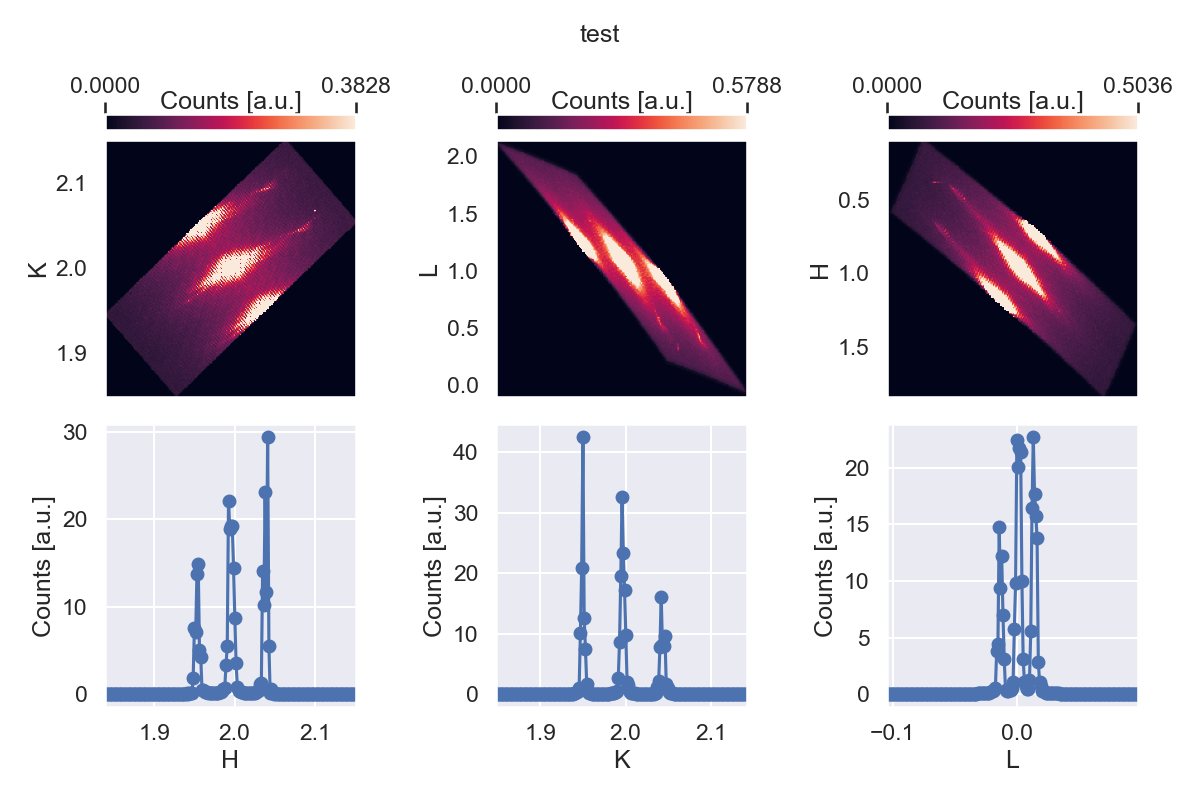

In [49]:
def mask_data(grid_data, xyz, HRange=(-np.inf, np.inf), KRange=(-np.inf, np.inf), LRange=(-np.inf, np.inf)):
    """Assign values out or range to NaN and return grid_data along with H, K, L axes"""
    H, K, L = xyz
    H_inds = (H >= HRange[0]) & (H <= HRange[1])
    K_inds = (K >= KRange[0]) & (K <= KRange[1])
    L_inds = (L >= LRange[0]) & (L <= LRange[1])
    
    return H[H_inds], K[K_inds], L[L_inds], grid_data[H_inds,:,:][:,K_inds,:][:,:,L_inds]


def plot_all(grid_data, xyz, title, bounds, HRange=None, KRange=None, LRange=None):
    HRange = HRange or bounds[0,0:2]
    KRange = KRange or bounds[1,0:2]
    LRange = LRange or bounds[2,0:2]

    [ax.cla() for ax in fig.get_axes()]

    H, K, L, data = mask_data(grid_data, xyz, HRange, KRange, LRange)
    HKL = [H, K, L]

    for i in range(3):
        x, y, integrate = i, (i + 1) % 3, (i + 2) % 3

        image = np.nanmean(data, axis=integrate)
        if x < y: image = image.T

        vminmax = np.nanpercentile(image, (2, 98))
        #c1 = ax1[i].pcolormesh(HKL[x], HKL[y], image,
        #                   vmin=vminmax[0], vmax=vminmax[1])
        c1 = ax1[i].imshow(image, extent = (HKL[x][0], HKL[x][-1], HKL[y][0], HKL[x][-1]),
                           vmin=vminmax[0], vmax=vminmax[1], origin='lower', aspect='auto')
        ax1[i].grid(False)

        cb = plt.colorbar(c1, ax=ax1[i], cax=caxs[i], orientation='horizontal',
                          ticks=np.linspace(*c1.get_clim(), 2))
        caxs[i].xaxis.set_ticks_position("top")

        cb.set_label('Counts [a.u.]', labelpad=-28)
        ax2[i].plot(HKL[x], np.nanmean(image, axis=0), '-o')

        ax2[i].set_xlabel('{}'.format(['H', 'K', 'L'][x]))
        ax2[i].set_ylabel('Counts [a.u.]')
        ax1[i].set_ylabel('{}'.format(['H', 'K', 'L'][y]))
        
    fig.suptitle(title, fontsize=18, y=0.97)


#style = {'description_width': 'initial'}
layout = widgets.Layout(width='30%')
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=3, figsize=(12,8), sharex='col', layout='tight')
fig.subplots_adjust(left=0.08, right=0.97, bottom=0.07, top=0.93, hspace=0.08, wspace=0.32)

caxs = []
for i in range(3):
    ax1_divider = make_axes_locatable(ax1[i])
    caxs.append(ax1_divider.append_axes("top", size="6%", pad="4%"))
    fig.add_axes(caxs[-1])

key = 'test'

h_min, h_max = np.min(x), np.max(x)
k_min, k_max = np.min(y), np.max(y)
l_min, l_max = np.min(z), np.max(z)

bounds = [
    [np.min(x), np.max(x), (np.max(x) - np.min(x))/x.shape[0]],
    [np.min(y), np.max(y), (np.max(y) - np.min(y))/y.shape[0]],
    [np.min(z), np.max(z), (np.max(z) - np.min(z))/z.shape[0]]
]

Hrange, Krange, Lrange = [[row[0], row[1], (row[1]-row[0])/row[2]] for row in bounds]
widgets.interact(
    plot_all, grid_data=fixed(intensity), xyz=fixed((x, y, z)), title=fixed(key), bounds=fixed(bounds),
    HRange=widgets.FloatRangeSlider(min=Hrange[0], max=Hrange[1], value=[Hrange[0], Hrange[1]], step=0.002, description='H', readout_format='.3f', layout=layout),
    KRange=widgets.FloatRangeSlider(min=Krange[0], max=Krange[1], value=[Krange[0], Krange[1]], step=0.002, description='K', readout_format='.3f', layout=layout),
    LRange=widgets.FloatRangeSlider(min=Lrange[0], max=Lrange[1], value=[Lrange[0], Lrange[1]], step=0.002, description='L', readout_format='.3f', layout=layout),
);

interactive(children=(FloatRangeSlider(value=(1.83874945048235, 2.15070981552051), description='H', layout=Lay…

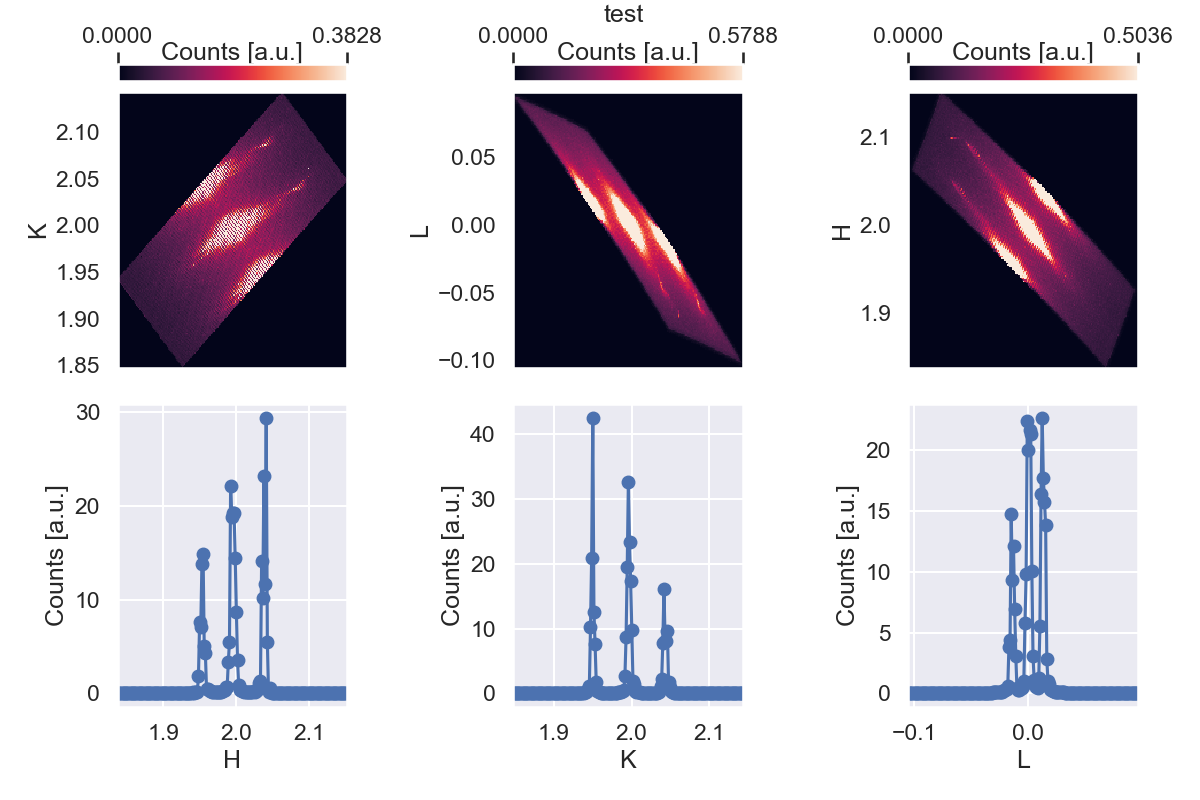

In [5]:
def mask_data(grid_data, xyz, HRange=(-np.inf, np.inf), KRange=(-np.inf, np.inf), LRange=(-np.inf, np.inf)):
    """Assign values out or range to NaN and return grid_data along with H, K, L axes"""
    H, K, L = xyz
    mask = reduce(np.logical_or, [
        H < HRange[0], H > HRange[1],
        K < KRange[0], K > KRange[1],
        L < LRange[0], L > LRange[1],
    ])
    masked_data = grid_data.copy()
    masked_data[mask] = np.NaN
    return H, K, L, masked_data



def plot_all(grid_data, xyz, title, bounds, HRange=None, KRange=None, LRange=None):
    if HRange is None: HRange = bounds[0,0:2]
    if KRange is None: KRange = bounds[1,0:2]
    if LRange is None: LRange = bounds[2,0:2]

    [ax.cla() for ax in fig.get_axes()]

    H, K, L, data = mask_data(grid_data, xyz, HRange, KRange, LRange)
    HKL = [H, K, L]

    for i in range(3):
        x, y, integrate = i, (i + 1) % 3, (i + 2) % 3

        image = np.nanmean(data, axis=integrate)
        if x < y: image = image.T

        c1 = ax1[i].pcolormesh(HKL[x], HKL[y], image,
                               vmin=np.nanpercentile(image, 2), vmax=np.nanpercentile(image, 98))

        cb = plt.colorbar(c1, ax=ax1[i], cax=caxs[i], orientation='horizontal',
                          ticks=np.linspace(*c1.get_clim(), 2))
        caxs[i].xaxis.set_ticks_position("top")

        cb.set_label('Counts [a.u.]', labelpad=-28)
        ax2[i].plot(HKL[x], np.nanmean(image, axis=0), '-o')

        ax2[i].set_xlabel('{}'.format(['H', 'K', 'L'][x]))
        ax2[i].set_ylabel('Counts [a.u.]')
        ax1[i].set_ylabel('{}'.format(['H', 'K', 'L'][y]))
        
    fig.text(0.52, 0.98, title, ha='center', va='center', fontsize=18)


#style = {'description_width': 'initial'}
layout = widgets.Layout(width='30%')
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=3, figsize=(12,8), sharex='col', layout='tight')
fig.subplots_adjust(left=0.08, right=0.97, bottom=0.07, top=0.93, hspace=0.08, wspace=0.32)

caxs = []
for i in range(3):
    ax1_divider = make_axes_locatable(ax1[i])
    caxs.append(ax1_divider.append_axes("top", size="6%", pad="4%"))
    fig.add_axes(caxs[-1])

key = 'test'

h_min, h_max = np.min(x), np.max(x)
k_min, k_max = np.min(y), np.max(y)
l_min, l_max = np.min(z), np.max(z)

bounds = [
    [np.min(x), np.max(x), (np.max(x) - np.min(x))/x.shape[0]],
    [np.min(y), np.max(y), (np.max(y) - np.min(y))/y.shape[0]],
    [np.min(z), np.max(z), (np.max(z) - np.min(z))/z.shape[0]]
]

Hrange, Krange, Lrange = [[row[0], row[1], (row[1]-row[0])/row[2]] for row in bounds]
widgets.interact(
    plot_all, grid_data=fixed(intensity), xyz=fixed((x, y, z)), title=fixed(key), bounds=fixed(bounds),
    HRange=widgets.FloatRangeSlider(min=Hrange[0], max=Hrange[1], value=[Hrange[0], Hrange[1]], step=0.002, description='H', readout_format='.3f', layout=layout),
    KRange=widgets.FloatRangeSlider(min=Krange[0], max=Krange[1], value=[Krange[0], Krange[1]], step=0.002, description='K', readout_format='.3f', layout=layout),
    LRange=widgets.FloatRangeSlider(min=Lrange[0], max=Lrange[1], value=[Lrange[0], Lrange[1]], step=0.002, description='L', readout_format='.3f', layout=layout),
);

interactive(children=(FloatRangeSlider(value=(1.83874945048235, 2.15070981552051), description='H', layout=Lay…

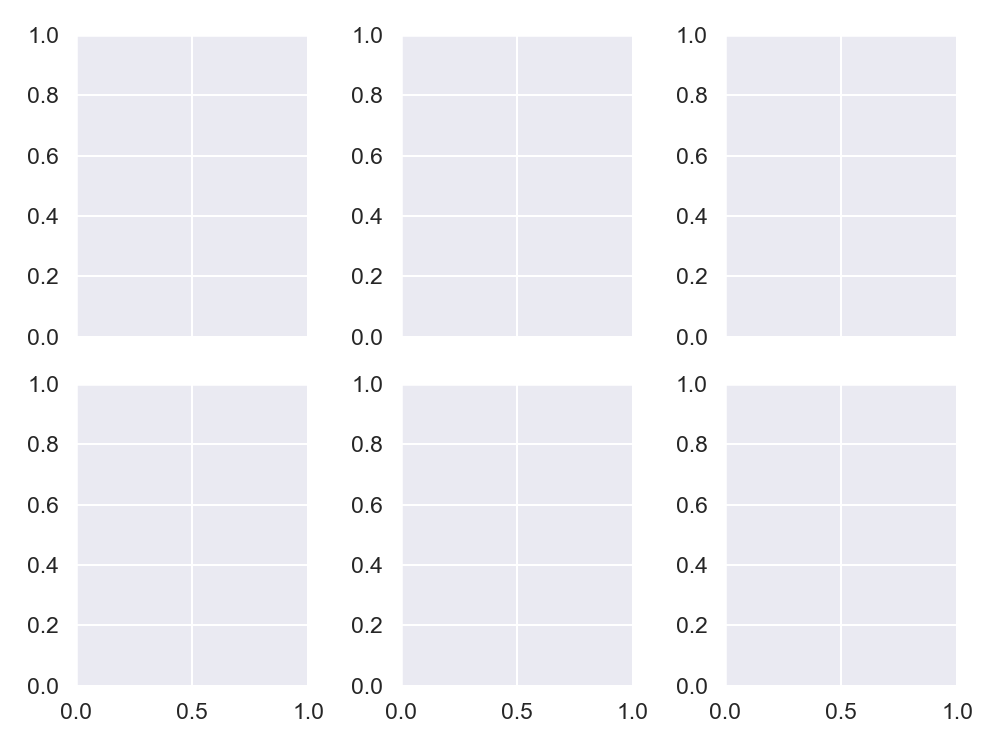

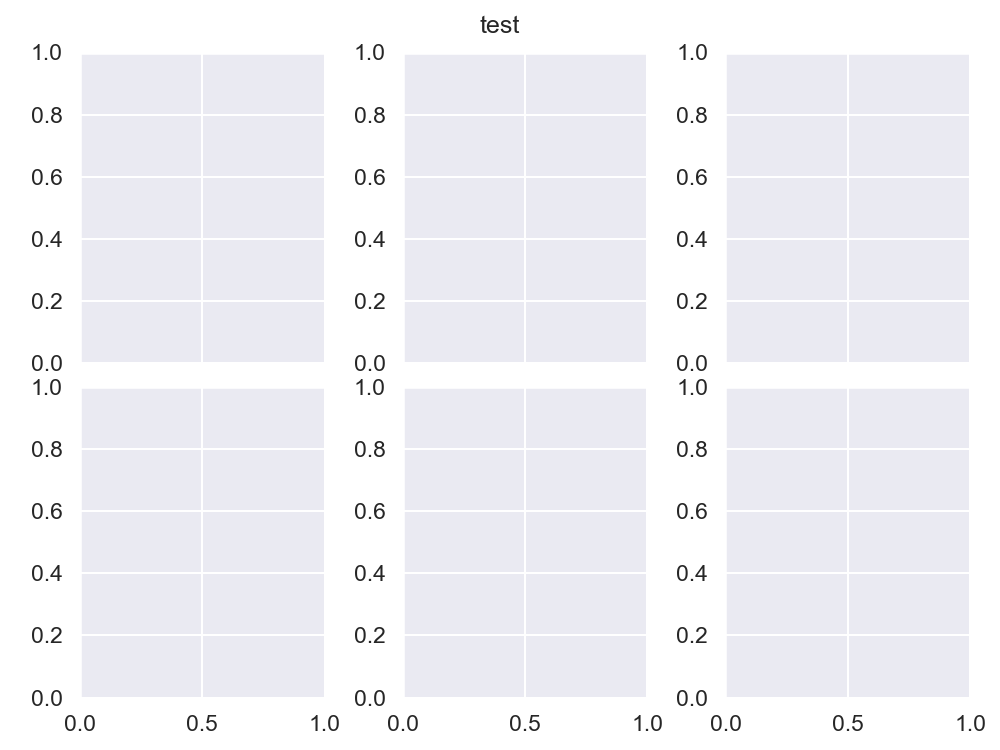

In [6]:
def mask_data(grid_data, xyz, bounds, HRange, KRange, LRange):
    """Mask data outside specified ranges and return H, K, L axes."""
    H, K, L = xyz
    mask = reduce(np.logical_or, [
        H < HRange[0], H > HRange[1],
        K < KRange[0], K > KRange[1],
        L < LRange[0], L > LRange[1],
    ])
    masked_data = grid_data.copy()
    masked_data[mask] = np.NaN
    return H, K, L, masked_data


def plot_all(grid_data, xyz, title, bounds, HRange, KRange, LRange):
    """Create 2D plots with projections and colorbars."""
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=3, figsize=(10, 7.5), sharex='col')
    fig.subplots_adjust(left=0.08, right=0.97, bottom=0.07, top=0.93, hspace=0.08, wspace=0.32)
    fig.suptitle(title, fontsize=18, y=0.98)  # Title position adjustment

    H, K, L, data = mask_data(grid_data, xyz, bounds, HRange, KRange, LRange)

    for i in range(3):
        x, y, integrate = i, (i + 1) % 3, (i + 2) % 3  # Axes indices
        image = np.nanmean(data, axis=integrate).T if x < y else np.nanmean(data, axis=integrate)

        im = ax1[i].pcolormesh(H[x], H[y], image,
                               vmin=np.nanpercentile(image, 2), vmax=np.nanpercentile(image, 98))

        fig.colorbar(im, ax=ax1[i], label='Counts [a.u.]', shrink=0.8)  # Add Colorbar

        ax2[i].plot(H[x], np.nanmean(image, axis=0), '-o')
        ax2[i].set_xlabel(['H', 'K', 'L'][x])
        ax2[i].set_ylabel('Counts [a.u.]')
        ax1[i].set_ylabel(['H', 'K', 'L'][y]) 


#style = {'description_width': 'initial'}
layout=widgets.Layout(width='30%')
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=3, figsize=(10,7.5), sharex='col', layout='tight')
fig.subplots_adjust(left=0.08, right=0.97, bottom=0.07, top=0.93, hspace=0.08, wspace=0.32)

##for i in range(3):
#    ax1_divider = make_axes_locatable(ax1[i])
#    cax = ax1_divider.append_axes("top", size="6%", pad="4%")
#    fig.add_axes(cax)

key = 'test'

h_min, h_max = np.min(x), np.max(x)
k_min, k_max = np.min(y), np.max(y)
l_min, l_max = np.min(z), np.max(z)

bounds = [
    [np.min(x), np.max(x), (np.max(x) - np.min(x))/x.shape[0]],
    [np.min(y), np.max(y), (np.max(y) - np.min(y))/y.shape[0]],
    [np.min(z), np.max(z), (np.max(z) - np.min(z))/z.shape[0]]
]

Hrange, Krange, Lrange = [[row[0], row[1], (row[1]-row[0])/row[2]] for row in bounds]
widgets.interact(
    plot_all, grid_data=fixed(intensity), xyz=fixed((x, y, z)), title=fixed(key), bounds=fixed(bounds),
    HRange=widgets.FloatRangeSlider(min=Hrange[0], max=Hrange[1], value=[Hrange[0], Hrange[1]], step=0.002, description='H', readout_format='.3f', layout=layout),
    KRange=widgets.FloatRangeSlider(min=Krange[0], max=Krange[1], value=[Krange[0], Krange[1]], step=0.002, description='K', readout_format='.3f', layout=layout),
    LRange=widgets.FloatRangeSlider(min=Lrange[0], max=Lrange[1], value=[Lrange[0], Lrange[1]], step=0.002, description='L', readout_format='.3f', layout=layout),
);

interactive(children=(FloatRangeSlider(value=(1.83874945048235, 2.15070981552051), description='H', layout=Lay…

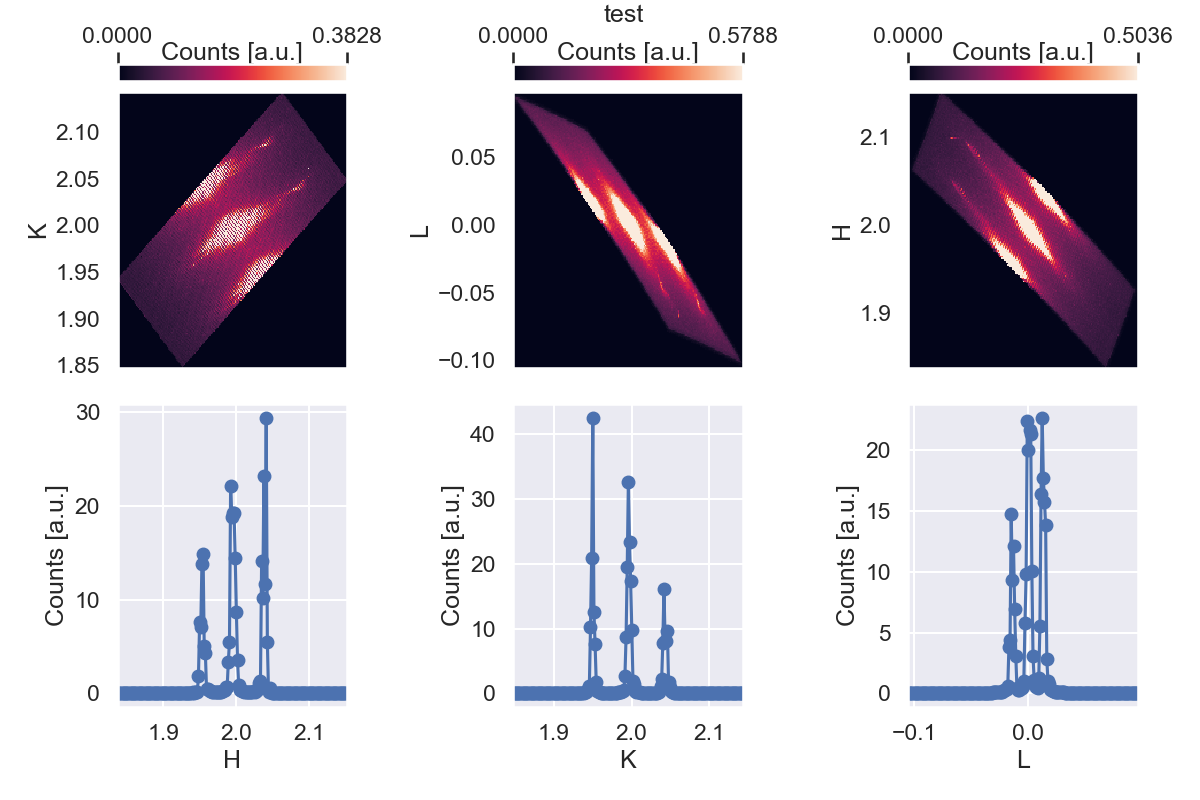

In [9]:
def get_angles(spec_file, scan_num, diff_motors=None, hkl_scan=False):
    # Extract angles from scan headers and scan data
    scan_data = SpecFile(str(spec_file))[scan_num - 1]

    angles_dict = {}
    if not hkl_scan:
        for dm in diff_motors:
            try:
                angles_dict[dm] = scan_data.data_column_by_name(dm)
            except:
                # angles_dict[dm] = np.repeat(scan_data.motor_position_by_name(dm), scan_data.data.shape[1])
                angles_dict[dm] = np.full(scan_data.data.shape[1], scan_data.motor_position_by_name(dm))
    else:
        motor_file = spec_file.parent / f"{spec_file.stem}_scan{scan_num:03d}_hklscan_motors.txt"
        angles_dict = pd.read_csv(motor_file).to_dict('list')
        
    return angles_dict


def get_energy_UB(spec_file, scan_num):
    """
    Extracts energy and UB matrix from SPEC file scan headers.
    """
    scan_data = SpecFile(str(spec_file))[scan_num - 1]
    energy = scan_data.motor_position_by_name('energy')
    
    header_dict = scan_data.scan_header_dict
    UB = np.array(header_dict['G3'].split()).astype(float).reshape(3,3)

    return energy, UB


def load_stack(scan_range, img_dir, spec_file, spec_name, parallel=True):
    """
    Loads a stack of images, applying parallelization if requested.
    """
    # Predefined constants and file templates
    db_pixel = [238, 98]  # Direct beam pixel
    pix_size = 172.0  # Pixel size in microns

    # File naming patterns
    data_template = os.path.join(img_dir, f"checkout_{spec_name}_scan{{}}_{{:04d}}.raw")
    sf = SpecFile(str(spec_file))
    energy, UB = get_energy_UB(spec_file, scan_num)
    diff_motors = ['del', 'eta', 'phi', 'chi', 'nu', 'mu']
    angles_dict = get_angles(spec_file, scan_num, diff_motors=diff_motors, hkl_scan=False)

    # Parallel or sequential reading of image data
    def read_scan_data(scan_num):
        scan = sf[scan_num - 1]
        num_points = np.shape(scan.data)[1]
        images = [read_image(data_template.format(scan_num, i), dtype='int32', header_skip=0) for i in range(num_points)]
        return np.array(images)

    if parallel:
        with Parallel(n_jobs=min(cpu_count(), len(scan_range))) as parallel:
            scan_data = parallel(delayed(read_scan_data)(sn) for sn in scan_range)
    else:
        scan_data = [read_scan_data(sn) for sn in scan_range]

    return np.array(scan_data), energy, UB, angles_dict


def grid_img_data(img, energy, UB, angles_dict):
    """
    Maps image data to reciprocal space, using a gridder for binning.
    """
    qconversion = xu.QConversion(['z-', 'y+', 'z-'], ['z-'], [0, 1, 0])
    hxrd = xu.HXRD([0, 1, 0], [0, 0, 1], en=energy, qconv=qconversion)
    hxrd.Ang2Q.init_area('x-', 'z-', cch1=238, cch2=98, Nch1=487, Nch2=195, pwidth1=0.172, pwidth2=0.172, distance=963.885)

    angle_values = [angles_dict[motor] for motor in ['eta', 'chi', 'phi', 'del']]
    qx, qy, qz = hxrd.Ang2Q.area(*angle_values, UB=UB)

    gridder = xu.Gridder3D(200, 200, 200)
    gridder(qx, qy, qz, img)
    return gridder.xaxis, gridder.yaxis, gridder.zaxis, gridder.data.astype(float)


def grid_img_data_(img, energy, UB, angles_dict):
    qconversion = xu.QConversion(sampleAxis=['z-','y+','z-'], detectorAxis=['z-'], r_i = [0,1,0])
    hxrd = xu.HXRD([0,1,0], [0,0,1], en=energy, qconv= qconversion)

    hxrd.Ang2Q.init_area(
            'x-', 'z-',
            cch1=238, cch2=98,
            Nch1=487, Nch2=195,
            pwidth1=0.172, pwidth2=0.172,
            distance=963.885
        )

    angle_values =   [angles_dict['eta'], angles_dict['chi'], angles_dict['phi'], angles_dict['del']]
    print([len(a) for a in angle_values], img.shape)
    qx, qy, qz = hxrd.Ang2Q.area(*angle_values, UB=UB)

    # Define the hkl grids to bin the diffraction data
    h_min,h_max = [np.min(qx), np.max(qx)]
    k_min,k_max = [np.min(qy), np.max(qy)]
    l_min,l_max = [np.min(qz), np.max(qz)]
    h_n, k_n, l_n = [200, 200, 200]

    gridder = xu.Gridder3D(nx=h_n, ny=k_n, nz=l_n)
    gridder.KeepData(True)
    gridder.dataRange(
        xmin=h_min, xmax=h_max,
        ymin=k_min, ymax=k_max,
        zmin=l_min, zmax=l_max,
        fixed=True
    )
    gridder(qx, qy, qz, img[:,:,:,:])


    # The output, the intensity and corresponding h,k,l 
    intensity = gridder.data.astype(float)
    x,y,z = gridder.xaxis, gridder.yaxis, gridder.zaxis
    return x, y, z, intensity



spec_name = 'He60e14'
spec_path = scans['He60e14_scan10']['spec_fpath']
scan_range = list(range(10, 11))

img, energy, UB, angles = load_stack(scan_range, img_fpath, spec_path, spec_name, parallel=True)
x, y, z, intensity = grid_img_data(img, energy, UB, angles)


def mask_data(grid_data, xyz, HRange=(-np.inf, np.inf), KRange=(-np.inf, np.inf), LRange=(-np.inf, np.inf)):
    """Assign values out or range to NaN and return grid_data along with H, K, L axes"""
    H, K, L = xyz
    mask = reduce(np.logical_or, [
        H < HRange[0], H > HRange[1],
        K < KRange[0], K > KRange[1],
        L < LRange[0], L > LRange[1],
    ])
    masked_data = grid_data.copy()
    masked_data[mask] = np.NaN
    return H, K, L, masked_data



def plot_all(grid_data, xyz, title, bounds, HRange=None, KRange=None, LRange=None):
    if HRange is None: HRange = bounds[0,0:2]
    if KRange is None: KRange = bounds[1,0:2]
    if LRange is None: LRange = bounds[2,0:2]

    [ax.cla() for ax in fig.get_axes()]

    H, K, L, data = mask_data(grid_data, xyz, HRange, KRange, LRange)
    HKL = [H, K, L]

    for i in range(3):
        x, y, integrate = i, (i + 1) % 3, (i + 2) % 3

        image = np.nanmean(data, axis=integrate)
        if x < y: image = image.T

        c1 = ax1[i].pcolormesh(HKL[x], HKL[y], image,
                               vmin=np.nanpercentile(image, 2), vmax=np.nanpercentile(image, 98))

        cb = plt.colorbar(c1, ax=ax1[i], cax=caxs[i], orientation='horizontal',
                          ticks=np.linspace(*c1.get_clim(), 2))
        caxs[i].xaxis.set_ticks_position("top")

        cb.set_label('Counts [a.u.]', labelpad=-28)
        ax2[i].plot(HKL[x], np.nanmean(image, axis=0), '-o')

        ax2[i].set_xlabel('{}'.format(['H', 'K', 'L'][x]))
        ax2[i].set_ylabel('Counts [a.u.]')
        ax1[i].set_ylabel('{}'.format(['H', 'K', 'L'][y]))
        
    fig.text(0.52, 0.98, title, ha='center', va='center', fontsize=18)


#style = {'description_width': 'initial'}
layout = widgets.Layout(width='30%')
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=3, figsize=(12,8), sharex='col', layout='tight')
fig.subplots_adjust(left=0.08, right=0.97, bottom=0.07, top=0.93, hspace=0.08, wspace=0.32)

caxs = []
for i in range(3):
    ax1_divider = make_axes_locatable(ax1[i])
    caxs.append(ax1_divider.append_axes("top", size="6%", pad="4%"))
    fig.add_axes(caxs[-1])

key = 'test'

h_min, h_max = np.min(x), np.max(x)
k_min, k_max = np.min(y), np.max(y)
l_min, l_max = np.min(z), np.max(z)

bounds = [
    [np.min(x), np.max(x), (np.max(x) - np.min(x))/x.shape[0]],
    [np.min(y), np.max(y), (np.max(y) - np.min(y))/y.shape[0]],
    [np.min(z), np.max(z), (np.max(z) - np.min(z))/z.shape[0]]
]

Hrange, Krange, Lrange = [[row[0], row[1], (row[1]-row[0])/row[2]] for row in bounds]
widgets.interact(
    plot_all, grid_data=fixed(intensity), xyz=fixed((x, y, z)), title=fixed(key), bounds=fixed(bounds),
    HRange=widgets.FloatRangeSlider(min=Hrange[0], max=Hrange[1], value=[Hrange[0], Hrange[1]], step=0.002, description='H', readout_format='.3f', layout=layout),
    KRange=widgets.FloatRangeSlider(min=Krange[0], max=Krange[1], value=[Krange[0], Krange[1]], step=0.002, description='K', readout_format='.3f', layout=layout),
    LRange=widgets.FloatRangeSlider(min=Lrange[0], max=Lrange[1], value=[Lrange[0], Lrange[1]], step=0.002, description='L', readout_format='.3f', layout=layout),
);

In [49]:

bounds

[[-0.048563419004971214, 0.04549799430366465, 0.0009406141330863587],
 [0.20103736791933677, 0.4640450158811622, 0.0026300764796182543],
 [6.151495035300948, 6.822648888534199, 0.0006711538532332515]]

interactive(children=(IntSlider(value=50, description='H Section:', max=99), IntSlider(value=50, description='…

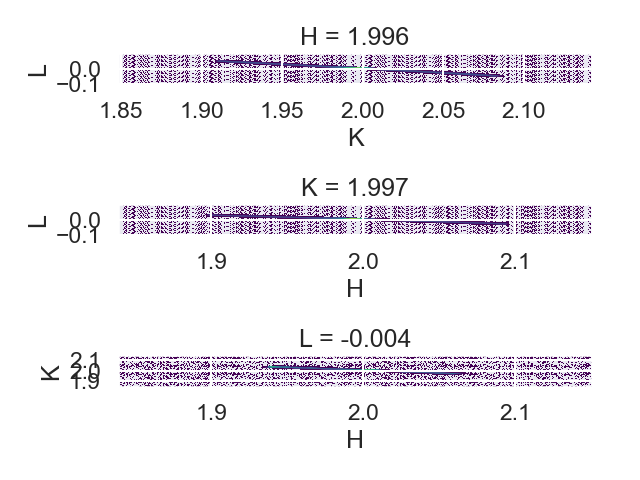

In [5]:
def plot_hyperspectral_data(intensity, qminmax, x_section, y_section, z_section):
    x_slice = intensity[x_section, :, :]
    y_slice = intensity[:, y_section, :]
    z_slice = intensity[:, :, z_section]

    normalization = 'log'
    h_min, h_max, k_min, k_max, l_min, l_max = qminmax

    fig, (ax1, ax2, ax3) = plt.subplots(3)
    #ax1 = plt.subplot(131)#,aspect=1.0)
    ax1.imshow(np.flipud(np.transpose(x_slice)), cmap='viridis', norm=normalization, aspect='auto', 
               extent = (k_min,k_max, l_min,l_max))
    ax1.set_xlabel('K')
    ax1.set_ylabel('L')
    ax1.set_title(f'H = {x[x_section]:.3f}')
    # ax1.set_aspect('equal')
    
    #ax2 = plt.subplot(132)#,aspect=1.0)
    ax2.imshow(np.flipud(np.transpose(y_slice)), cmap='viridis', norm=normalization, aspect='auto', 
               extent = (h_min,h_max, l_min,l_max))
    ax2.set_xlabel('H')
    ax2.set_ylabel('L')
    ax2.set_title(f'K = {y[y_section]:.3f}')
    # ax2.set_aspect('equal')    
    
    #ax3 = plt.subplot(133)#,aspect=1.0)
    ax3.imshow(np.flipud(np.transpose(z_slice)), cmap='viridis', norm=normalization, aspect='auto', 
               extent = (h_min,h_max, k_min,k_max))
    ax3.set_xlabel('H')
    ax3.set_ylabel('K')
    ax3.set_title(f'L = {z[z_section]:.3f}')
    # ax3.set_aspect('equal')
    plt.tight_layout()


# Wrapper function to handle interactive plotting with ipywidgets
def interactive_plotting(intensity):
    xlen, ylen, zlen = intensity.shape
    h_min, h_max = np.min(x), np.max(x)
    k_min, k_max = np.min(y), np.max(y)
    l_min, l_max = np.min(z), np.max(z)

    qminmax = [h_min, h_max, k_min, k_max, l_min, l_max]

    # Define sliders
    x_slider = widgets.IntSlider(min=0, max=xlen - 1, step=1, value=xlen // 2, description='H Section:')
    y_slider = widgets.IntSlider(min=0, max=ylen - 1, step=1, value=ylen // 2, description='K Section:')
    z_slider = widgets.IntSlider(min=0, max=zlen - 1, step=1, value=zlen // 2, description='L Section:')

    # Setup interactive plotting
    interact(plot_hyperspectral_data, x_section=x_slider, y_section=y_slider, z_section=z_slider,
             intensity=fixed(intensity), qminmax=fixed(qminmax))


interactive_plotting(intensity)

In [62]:
import xrayutilities as xu
import numpy as np
import matplotlib.pyplot as plt  # For optional visualization

# ------------------
#  Settings 
# ------------------
data_dir = 'path/to/your/data'
file_prefix = 'psic_image_'   
num_images = 100
detector_distance = 150.0 
pixel_size = 0.172  
beam_center_x = 500  
beam_center_y = 400 

# ------------------
#  Load experimental data
# ------------------
UB = np.loadtxt("UB_matrix.txt") 
eta_angles = np.loadtxt("eta_angles.txt")  
del_angles = np.loadtxt("del_angles.txt") 
chi_angles = np.loadtxt("chi_angles.txt") 
phi_angles = np.loadtxt("phi_angles.txt") 
mu_angles = np.loadtxt("mu_angles.txt") 
nu_angles = np.loadtxt("nu_angles.txt") 

# --------
#  Main loop
# --------
for i in range(num_images):
    filepath = os.path.join(data_dir, file_prefix + f'{i+1:04d}.edf')  

    # Load image data
    det = xu.io.EDFLoader(filepath, correct_beam_center=True, 
                          center_x=beam_center_x, center_y=beam_center_y) 

    # Experimental geometry 
    exp = xu.simphys.Experiment(UB=UB) 
    exp.detector.distance = detector_distance
    exp.detector.pixel_size = (pixel_size, pixel_size) 
    exp.g6.eta = eta_angles[i]
    exp.g6.del_ = del_angles[i] 
    exp.g6.chi = chi_angles[i]
    exp.g6.phi = phi_angles[i]
    exp.g6.mu = mu_angles[i]
    exp.g6.nu = nu_angles[i]

    # Conversion to reciprocal space
    gridder = xu.simphys.Gridder2D(det.data.shape, *exp.Ang2Q(det.coords()))
    gridder.set_data(det.coords(), det.data)
    qmap = gridder.grid()

    # Optional: Visualize a slice of reciprocal space
    plt.imshow(qmap[0], cmap='viridis', origin='lower')
    plt.xlabel("Qx")
    plt.ylabel("Qy")
    plt.title(f"Reciprocal Space Map: Image {i+1}")
    plt.show()

    # Optional: Save the reciprocal space map
    # np.savetxt(f"reciprocal_map_{i+1}.txt", qmap) 

(100,)

In [65]:
H, K, L = (x, y, z)
H

array([-0.04856342, -0.0476133 , -0.04666319, -0.04571307, -0.04476296,
       -0.04381284, -0.04286273, -0.04191261, -0.0409625 , -0.04001238,
       -0.03906227, -0.03811215, -0.03716204, -0.03621192, -0.03526181,
       -0.03431169, -0.03336157, -0.03241146, -0.03146134, -0.03051123,
       -0.02956111, -0.028611  , -0.02766088, -0.02671077, -0.02576065,
       -0.02481054, -0.02386042, -0.02291031, -0.02196019, -0.02101008,
       -0.02005996, -0.01910985, -0.01815973, -0.01720961, -0.0162595 ,
       -0.01530938, -0.01435927, -0.01340915, -0.01245904, -0.01150892,
       -0.01055881, -0.00960869, -0.00865858, -0.00770846, -0.00675835,
       -0.00580823, -0.00485812, -0.003908  , -0.00295789, -0.00200777,
       -0.00105765, -0.00010754,  0.00084258,  0.00179269,  0.00274281,
        0.00369292,  0.00464304,  0.00559315,  0.00654327,  0.00749338,
        0.0084435 ,  0.00939361,  0.01034373,  0.01129384,  0.01224396,
        0.01319407,  0.01414419,  0.01509431,  0.01604442,  0.01

In [64]:
xyz[0]

array([-0.04856342, -0.0476133 , -0.04666319, -0.04571307, -0.04476296,
       -0.04381284, -0.04286273, -0.04191261, -0.0409625 , -0.04001238,
       -0.03906227, -0.03811215, -0.03716204, -0.03621192, -0.03526181,
       -0.03431169, -0.03336157, -0.03241146, -0.03146134, -0.03051123,
       -0.02956111, -0.028611  , -0.02766088, -0.02671077, -0.02576065,
       -0.02481054, -0.02386042, -0.02291031, -0.02196019, -0.02101008,
       -0.02005996, -0.01910985, -0.01815973, -0.01720961, -0.0162595 ,
       -0.01530938, -0.01435927, -0.01340915, -0.01245904, -0.01150892,
       -0.01055881, -0.00960869, -0.00865858, -0.00770846, -0.00675835,
       -0.00580823, -0.00485812, -0.003908  , -0.00295789, -0.00200777,
       -0.00105765, -0.00010754,  0.00084258,  0.00179269,  0.00274281,
        0.00369292,  0.00464304,  0.00559315,  0.00654327,  0.00749338,
        0.0084435 ,  0.00939361,  0.01034373,  0.01129384,  0.01224396,
        0.01319407,  0.01414419,  0.01509431,  0.01604442,  0.01

In [53]:
# Setup and configuration
warnings.filterwarnings('ignore')
base_path = Path('/msd_data/checkout/bl17-2/user_data/2024_02_Stoica/')
img_fpath = base_path.joinpath('images')
cmap = 'magma'
spec_names_scan_nums = [('PTO_STO_S2', range(3, 4))]

# Improved image reader
def read_image(file, shape=(195, 487), dtype='int32', header_skip=4096, flip=False):
    try:
        with open(file, 'rb') as im:
            if header_skip:
                im.seek(header_skip)
            arr = np.frombuffer(im.read(), dtype=dtype).reshape(shape)
            if flip:
                arr = np.fliplr(arr)
        return arr
    except Exception as e:
        print(f"Error reading file: {file}, Error: {e}")
        return None

# Extract data from spec file
def extract_spec_data(spec_file, scan_num):
    sf = SpecFile(str(spec_file))
    scan = sf[scan_num - 1]
    return {
        'labels': scan.labels,
        'data': scan.data,
        'scan_header_dict': scan.scan_header_dict,
        'motor_positions': {motor: scan.motor_position_by_name(motor) for motor in scan.motors}
    }

# Load image stack with parallel option
def load_stack(scan_nums, img_dir, spec_info, parallel=True):
    def read_scan_images(scan_num):
        img_files = sorted(img_dir.glob(f'checkout_{spec_info["name"]}_scan{scan_num}_*.raw'))
        return np.array([read_image(file) for file in img_files])

    if parallel:
        num_cores = min(cpu_count(), len(scan_nums))
        images = Parallel(n_jobs=num_cores)(delayed(read_scan_images)(sn) for sn in scan_nums)
    else:
        images = [read_scan_images(sn) for sn in scan_nums]
    return np.concatenate(images)

# Q-conversion and gridding
def grid_img_data(images, spec_info):
    # Setup Q-conversion parameters based on spec_info (modify as per actual PSIC geometry)
    qconv = xu.QConversion(['z-', 'y+', 'z-'], ['z-'], [0, 1, 0])
    hxrd = xu.HXRD([0, 1, 0], [0, 0, 1], en=spec_info['energy'], qconv=qconv)
    hxrd.Ang2Q.init_area('x-', 'z-', cch1=238, cch2=98, Nch1=487, Nch2=195, pwidth1=0.172, pwidth2=0.172, distance=963.885)

    # Convert angles to Q-space and grid data
    # Assume angles_dict contains proper motor names as keys and arrays as values
    angles_dict = spec_info['angles']
    qx, qy, qz = hxrd.Ang2Q.area(angles_dict['eta'], angles_dict['chi'], angles_dict['phi'], angles_dict['del'], UB=spec_info['UB'])

    gridder = xu.Gridder3D(100, 100, 1000)
    gridder.keep_data(True)
    gridder(qx, qy, qz, images)
    return gridder.xaxis, gridder.yaxis, gridder.zaxis, gridder.data.astype(float)


def plot_hyperspectral_data(intensity, qminmax, x_section, y_section, z_section):
    # Unpack the qminmax for plotting limits
    h_min, h_max, k_min, k_max, l_min, l_max = qminmax
    
    # Extract slices based on selected sections
    x_slice = intensity[x_section, :, :]
    y_slice = intensity[:, y_section, :]
    z_slice = intensity[:, :, z_section]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Configure normalization if necessary. For log scale: matplotlib.colors.LogNorm()
    norm = None  # Replace with your normalization, e.g., LogNorm()
    
    # Plotting the slices
    im1 = axes[0].imshow(np.flipud(x_slice.T), cmap=cmap, aspect='auto', extent=(k_min, k_max, l_min, l_max), norm=norm)
    axes[0].set_xlabel('K')
    axes[0].set_ylabel('L')
    axes[0].set_title(f'H = {x[x_section]:.3f}')
    
    im2 = axes[1].imshow(np.flipud(y_slice.T), cmap=cmap, aspect='auto', extent=(h_min, h_max, l_min, l_max), norm=norm)
    axes[1].set_xlabel('H')
    axes[1].set_ylabel('L')
    axes[1].set_title(f'K = {y[y_section]:.3f}')
    
    im3 = axes[2].imshow(np.flipud(z_slice.T), cmap=cmap, aspect='auto', extent=(h_min, h_max, k_min, k_max), norm=norm)
    axes[2].set_xlabel('H')
    axes[2].set_ylabel('K')
    axes[2].set_title(f'L = {z[z_section]:.3f}')
    
    # Enhance layout and add colorbars for clarity
    fig.colorbar(im1, ax=axes[0], orientation='vertical')
    fig.colorbar(im2, ax=axes[1], orientation='vertical')
    fig.colorbar(im3, ax=axes[2], orientation='vertical')
    plt.tight_layout()

def interactive_plotting(intensity, x, y, z):
    # Define the limits for qminmax based on the grid axes
    qminmax = [np.min(x), np.max(x), np.min(y), np.max(y), np.min(z), np.max(z)]
    
    # Setup sliders for interactive plotting
    x_slider = widgets.IntSlider(min=0, max=len(x) - 1, step=1, value=len(x) // 2, description='H Section:')
    y_slider = widgets.IntSlider(min=0, max=len(y) - 1, step=1, value=len(y) // 2, description='K Section:')
    z_slider = widgets.IntSlider(min=0, max=len(z) - 1, step=1, value=len(z) // 2, description='L Section:')
    
    interact(plot_hyperspectral_data, intensity=fixed(intensity), qminmax=fixed(qminmax),
             x_section=x_slider, y_section=y_slider, z_section=z_slider)


# Example usage
for spec_name, scan_nums in spec_names_scan_nums:
    spec_fpath = base_path / spec_name / spec_name
    spec_info = extract_spec_data(spec_fpath, list(scan_nums)[0])  # Assuming single scan for simplicity
    images = load_stack(scan_nums, img_fpath, {'name': spec_name, 'energy': 8.0}, parallel=True)  # Placeholder for energy
    x, y, z, intensity = grid_img_data(images, spec_info)
    # Following functions like interactive_plotting() should be defined similarly to previous versions or streamlined as needed


# Example usage (replace intensity, x, y, z with actual data variables)
interactive_plotting(intensity, x, y, z)

AttributeError: 'Scan' object has no attribute 'motors'

In [7]:
base_path = Path(r'/msd_data/checkout/bl17-2/user_data/2024_02_Stoica/')
img_fpath = base_path.joinpath('images')

scans = OrderedDict()

spec_names_scan_nums = [
    ('PTO_STO_S2', list(range(3,4))),
]

for spec_name, scan_nums in spec_names_scan_nums:
    spec_fpath = base_path.joinpath(spec_name, spec_name)
    for scan_num in scan_nums:
        scans[f'{spec_name}_scan{scan_num}'] = {
            'spec_fpath': spec_fpath,
            'scan_num': scan_num,
            'img_fnames': os_sorted(list(img_fpath.glob(f'checkout_{spec_name}_scan{scan_num}_*.raw')))
        }

In [50]:
def load_stack(scan_range, img_dir, spec_path, spec_name, parallel=True):
    # Predefined constants and file templates
    db_pixel = [238, 98]  # Direct beam pixel
    pix_size = 172.0  # Pixel size in microns

    # File naming patterns
    data_template = os.path.join(img_dir, f"checkout_{spec_name}_scan{{}}_{{:04d}}.raw")
    # spec_file = os.path.join(spec_path, spec_name)
    spec_file = spec_path

    # Read SPEC file to get experiment metadata
    sf = SpecFile(str(spec_file))
    scan_data, UB, angles, energy = [], None, [], None

    energy, UB = get_energy_UB(spec_file, scan_num)
    diff_motors = ['del', 'eta', 'phi', 'chi', 'nu', 'mu']
    angles_dict = get_angles(spec_file, scan_num, diff_motors=diff_motors)

    # Parallel or sequential reading of image data
    def read_scan_data(scan_num):
        scan = sf[scan_num - 1]
        num_points = np.shape(scan.data)[1]
        images = [read_image(data_template.format(scan_num, i), dtype='int32', header_skip=0) for i in range(num_points)]
        return np.array(images)

    if parallel:
        num_cores = min(cpu_count(), len(scan_range))  # Limit to available CPUs or scans
        scan_data = Parallel(n_jobs=num_cores)(delayed(read_scan_data)(sn) for sn in scan_range)
    else:
        for sn in scan_range:
            scan_data.append(read_scan_data(sn))

    # Return combined data from all scans
    return np.array(scan_data), energy, UB, angles_dict  # This array would be used for subsequent analysis


def grid_img_data(img, energy, UB, angles_dict):
    qconversion = xu.QConversion(sampleAxis=['z-','y+','z-'], detectorAxis=['z-'], r_i = [0,1,0])
    hxrd = xu.HXRD([0,1,0], [0,0,1], en=energy, qconv= qconversion)

    hxrd.Ang2Q.init_area(
            'x-', 'z-',
            cch1=238, cch2=98,
            Nch1=487, Nch2=195,
            pwidth1=0.172, pwidth2=0.172,
            distance=963.885
        )

    angle_values =   [angles_dict['eta'], angles_dict['chi'], angles_dict['phi'], angles_dict['del']]
    qx, qy, qz = hxrd.Ang2Q.area(*angle_values, UB=UB)

    # Define the hkl grids to bin the diffraction data
    h_min,h_max = [np.min(qx), np.max(qx)]
    k_min,k_max = [np.min(qy), np.max(qy)]
    l_min,l_max = [np.min(qz), np.max(qz)]
    h_n, k_n, l_n = [100, 100, 1000]

    gridder = xu.Gridder3D(nx=h_n, ny=k_n, nz=l_n)
    gridder.KeepData(True)
    gridder.dataRange(
        xmin=h_min, xmax=h_max,
        ymin=k_min, ymax=k_max,
        zmin=l_min, zmax=l_max,
        fixed=True
    )
    gridder(qx, qy, qz, img)


    # The output, the intensity and corresponding h,k,l 
    intensity = gridder.data.astype(float)
    x,y,z = gridder.xaxis, gridder.yaxis, gridder.zaxis
    return x, y, z, intensity


def plot_hyperspectral_data(intensity, qminmax, x_section, y_section, z_section):
    x_slice = intensity[x_section, :, :]
    y_slice = intensity[:, y_section, :]
    z_slice = intensity[:, :, z_section]

    normalization = 'log'
    h_min, h_max, k_min, k_max, l_min, l_max = qminmax

    fig, (ax1, ax2, ax3) = plt.subplots(3)
    #ax1 = plt.subplot(131)#,aspect=1.0)
    ax1.imshow(np.flipud(np.transpose(x_slice)), cmap='viridis', norm=normalization, aspect='auto', 
               extent = (k_min,k_max, l_min,l_max))
    ax1.set_xlabel('K')
    ax1.set_ylabel('L')
    ax1.set_title(f'H = {x[x_section]:.3f}')
    # ax1.set_aspect('equal')
    
    #ax2 = plt.subplot(132)#,aspect=1.0)
    ax2.imshow(np.flipud(np.transpose(y_slice)), cmap='viridis', norm=normalization, aspect='auto', 
               extent = (h_min,h_max, l_min,l_max))
    ax2.set_xlabel('H')
    ax2.set_ylabel('L')
    ax2.set_title(f'K = {y[y_section]:.3f}')
    # ax2.set_aspect('equal')    
    
    #ax3 = plt.subplot(133)#,aspect=1.0)
    ax3.imshow(np.flipud(np.transpose(z_slice)), cmap='viridis', norm=normalization, aspect='auto', 
               extent = (h_min,h_max, k_min,k_max))
    ax3.set_xlabel('H')
    ax3.set_ylabel('K')
    ax3.set_title(f'L = {z[z_section]:.3f}')
    # ax3.set_aspect('equal')
    plt.tight_layout()


# Wrapper function to handle interactive plotting with ipywidgets
def interactive_plotting(intensity):
    xlen, ylen, zlen = intensity.shape
    h_min, h_max = np.min(x), np.max(x)
    k_min, k_max = np.min(y), np.max(y)
    l_min, l_max = np.min(z), np.max(z)

    qminmax = [h_min, h_max, k_min, k_max, l_min, l_max]

    # Define sliders
    x_slider = widgets.IntSlider(min=0, max=xlen - 1, step=1, value=xlen // 2, description='H Section:')
    y_slider = widgets.IntSlider(min=0, max=ylen - 1, step=1, value=ylen // 2, description='K Section:')
    z_slider = widgets.IntSlider(min=0, max=zlen - 1, step=1, value=zlen // 2, description='L Section:')

    # Setup interactive plotting
    interact(plot_hyperspectral_data, x_section=x_slider, y_section=y_slider, z_section=z_slider,
             intensity=fixed(intensity), qminmax=fixed(qminmax))

In [40]:
spec_name = 'PTO_STO_S2'
spec_path = scans['PTO_STO_S2_scan3']['spec_fpath']
scan_range = list(range(3,4))

img, energy, UB, angles = load_stack(scan_range, img_fpath, spec_path, spec_name, parallel=True)
x, y, z, intensity = grid_img_data(img, energy, UB, angles)

interactive_plotting(intensity)

interactive(children=(IntSlider(value=50, description='H Section:', max=99), IntSlider(value=50, description='…

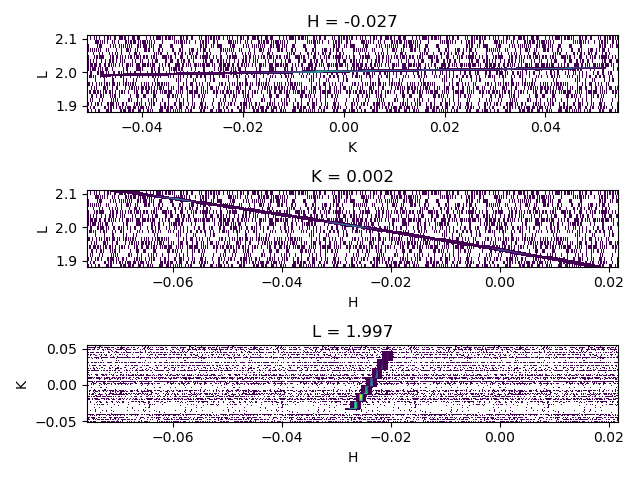

In [51]:
interactive_plotting(intensity)

In [35]:
intensity.mean()

0.623846864568764

In [ ]:
sf = SpecFile(spec_file)
scan = sf[scan_num-1]
num_points = np.shape(scan.data)[1]


def loadstack(scan_num1, scan_num2):
    # Useful information for calibration goes here
    scan_num = scan_num1

    db_pixel = [238, 98]  # direct beam pixel
    pix_size = 172.0  # pixel size in microns

    data_path = "/msd_data/checkout/bl17-2/user_data/Dec2023_Li/images/"
    data_name = "checkout_STO_scan"+str(scan_num)+"_"

    csv_path = "/msd_data/checkout/bl17-2/user_data/Dec2023_Li/STO/"
    csv_name = "STO_scan"+str(scan_num)+".csv"
    csv_file = os.path.join(csv_path, csv_name)

    spec_path = csv_path
    spec_name = 'STO'
    spec_file = os.path.join(spec_path, spec_name)

    motor_name = "STO_scan"+str(scan_num).zfill(3)+"_hklscan_motors.txt"
    motor_file = os.path.join(spec_path, motor_name)

    # Read SPEC file, get headers
    sf = SpecFile(spec_file)
    scan = sf[scan_num-1]
    num_points = np.shape(scan.data)[1]
    print('scan number: ' + str(scan.number) + ', length: ' + str(np.shape(scan.data)[1]))

    energy, UB = get_energy_UB(spec_file, scan_num)

    diff_motors = ['del', 'eta', 'phi', 'chi', 'nu', 'mu']
    angles_dict = get_angles(spec_file, scan_num, diff_motors=)

    # read images
    for i in np.arange(0, num_points):
        filename = data_path + data_name + str(i).zfill(4) + ".raw"
        data = np.swapaxes(read_RAW(filename),0,1)
        if i==0:
            img = [data]
        else:
            img += [data]

    qconversion = xu.QConversion(sampleAxis = ['z-','y+','z-'], detectorAxis = ['z-'], r_i = [0,1,0])

    hxrd = xu.HXRD( [0,1,0], [0,0,1], en = energy, qconv =  qconversion)

    hxrd.Ang2Q.init_area(
            'x-', 'z-',
            cch1=238, cch2=98,
            Nch1=487, Nch2=195,
            pwidth1=0.172, pwidth2=0.172,
            distance=963.885
        )

    angle_values =   [eta, chi, phi, tt]   #[[26.056],  [13.028]]
    qx, qy, qz = hxrd.Ang2Q.area(*angle_values, UB=UB)

    img = np.array(img)

    # Define the hkl grids to bin the diffraction data
    h_min,h_max = [np.min(qx), np.max(qx)]
    k_min,k_max = [np.min(qy), np.max(qy)]
    l_min,l_max = [np.min(qz), np.max(qz)]
    h_n, k_n, l_n = [100, 100, 1000]

    gridder = xu.Gridder3D(nx=h_n, ny=k_n, nz=l_n)
    gridder.KeepData(True)
    gridder.dataRange(
        xmin=h_min, xmax=h_max,
        ymin=k_min, ymax=k_max,
        zmin=l_min, zmax=l_max,
        fixed=True
    )
    gridder(qx, qy, qz, img)


    # The output, the intensity and corresponding h,k,l 
    intensity = gridder.data.astype(float)
    x,y,z = gridder.xaxis, gridder.yaxis, gridder.zaxis
    return x,y,z,intensity

def plot_hyperspectral_data(x_section,y_section,z_section):
    x_slice = intensity[x_section, :, :]
    y_slice = intensity[:, y_section, :]
    z_slice = intensity[:, :, z_section]
    
    ax1 = plt.subplot(131)#,aspect=1.0)
    ax1.imshow(np.flipud(np.transpose(x_slice)), cmap='viridis', norm = normalization, aspect='auto', 
               extent = (k_min,k_max, l_min,l_max))
    ax1.set_xlabel('K')
    ax1.set_ylabel('L')
    ax1.set_title(f'H = {x[x_section]:.3f}')
    # ax1.set_aspect('equal')
    
    ax2 = plt.subplot(132)#,aspect=1.0)
    ax2.imshow(np.flipud(np.transpose(y_slice)), cmap='viridis', norm = normalization, aspect='auto', 
               extent = (h_min,h_max, l_min,l_max))
    ax2.set_xlabel('H')
    ax2.set_ylabel('L')
    ax2.set_title(f'K = {y[y_section]:.3f}')
    # ax2.set_aspect('equal')    
    
    ax3 = plt.subplot(133)#,aspect=1.0)
    ax3.imshow(np.flipud(np.transpose(z_slice)), cmap='viridis', norm = normalization, aspect='auto', 
               extent = (h_min,h_max, k_min,k_max))
    ax3.set_xlabel('H')
    ax3.set_ylabel('K')
    ax3.set_title(f'L = {z[z_section]:.3f}')
    # ax3.set_aspect('equal')
    plt.tight_layout()

In [ ]:
def loadstack(scan_num1, scan_num2):
    # Useful information for calibration goes here
    scan_num = scan_num1

    db_pixel = [238, 98]  # direct beam pixel
    pix_size = 172.0  # pixel size in microns

    data_path = "/msd_data/checkout/bl17-2/user_data/Dec2023_Li/images/"
    data_name = "checkout_STO_scan"+str(scan_num)+"_"

    csv_path = "/msd_data/checkout/bl17-2/user_data/Dec2023_Li/STO/"
    csv_name = "STO_scan"+str(scan_num)+".csv"
    csv_file = os.path.join(csv_path, csv_name)

    spec_path = csv_path
    spec_name = 'STO'
    spec_file = os.path.join(spec_path, spec_name)

    motor_name = "STO_scan"+str(scan_num).zfill(3)+"_hklscan_motors.txt"
    motor_file = os.path.join(spec_path, motor_name)

    # Read SPEC file, get headers
    sf = SpecFile(spec_file)
    scan = sf[scan_num-1]
    num_points = np.shape(scan.data)[1]
    print('scan number: ' + str(scan.number) + ', length: ' + str(np.shape(scan.data)[1]))

    energy, UB = get_energy_UB(spec_file, scan_num)

    diff_motors = ['del', 'eta', 'phi', 'chi', 'nu', 'mu']
    angles_dict = get_angles(spec_file, scan_num, diff_motors=)

    # read images
    for i in np.arange(0, num_points):
        filename = data_path + data_name + str(i).zfill(4) + ".raw"
        data = np.swapaxes(read_RAW(filename),0,1)
        if i==0:
            img = [data]
        else:
            img += [data]

    qconversion = xu.QConversion(sampleAxis = ['z-','y+','z-'], detectorAxis = ['z-'], r_i = [0,1,0])

    hxrd = xu.HXRD( [0,1,0], [0,0,1], en = energy, qconv =  qconversion)

    hxrd.Ang2Q.init_area(
            'x-', 'z-',
            cch1=238, cch2=98,
            Nch1=487, Nch2=195,
            pwidth1=0.172, pwidth2=0.172,
            distance=963.885
        )

    angle_values =   [eta, chi, phi, tt]   #[[26.056],  [13.028]]
    qx, qy, qz = hxrd.Ang2Q.area(*angle_values, UB=UB)

    img = np.array(img)

    # Define the hkl grids to bin the diffraction data
    h_min,h_max = [np.min(qx), np.max(qx)]
    k_min,k_max = [np.min(qy), np.max(qy)]
    l_min,l_max = [np.min(qz), np.max(qz)]
    h_n, k_n, l_n = [100, 100, 1000]

    gridder = xu.Gridder3D(nx=h_n, ny=k_n, nz=l_n)
    gridder.KeepData(True)
    gridder.dataRange(
        xmin=h_min, xmax=h_max,
        ymin=k_min, ymax=k_max,
        zmin=l_min, zmax=l_max,
        fixed=True
    )
    gridder(qx, qy, qz, img)


    # The output, the intensity and corresponding h,k,l 
    intensity = gridder.data.astype(float)
    x,y,z = gridder.xaxis, gridder.yaxis, gridder.zaxis
    return x,y,z,intensity

def plot_hyperspectral_data(x_section,y_section,z_section):
    x_slice = intensity[x_section, :, :]
    y_slice = intensity[:, y_section, :]
    z_slice = intensity[:, :, z_section]
    
    ax1 = plt.subplot(131)#,aspect=1.0)
    ax1.imshow(np.flipud(np.transpose(x_slice)), cmap='viridis', norm = normalization, aspect='auto', 
               extent = (k_min,k_max, l_min,l_max))
    ax1.set_xlabel('K')
    ax1.set_ylabel('L')
    ax1.set_title(f'H = {x[x_section]:.3f}')
    # ax1.set_aspect('equal')
    
    ax2 = plt.subplot(132)#,aspect=1.0)
    ax2.imshow(np.flipud(np.transpose(y_slice)), cmap='viridis', norm = normalization, aspect='auto', 
               extent = (h_min,h_max, l_min,l_max))
    ax2.set_xlabel('H')
    ax2.set_ylabel('L')
    ax2.set_title(f'K = {y[y_section]:.3f}')
    # ax2.set_aspect('equal')    
    
    ax3 = plt.subplot(133)#,aspect=1.0)
    ax3.imshow(np.flipud(np.transpose(z_slice)), cmap='viridis', norm = normalization, aspect='auto', 
               extent = (h_min,h_max, k_min,k_max))
    ax3.set_xlabel('H')
    ax3.set_ylabel('K')
    ax3.set_title(f'L = {z[z_section]:.3f}')
    # ax3.set_aspect('equal')
    plt.tight_layout()

In [2]:
import numpy as np
import os
import xrayutilities as xu
import matplotlib.pyplot as plt
from silx.io.specfile import SpecFile
from matplotlib import gridspec
import fabio
import pandas as pd
from joblib import Parallel, delayed
import ipywidgets as widgets
from ipywidgets import interact
from multiprocessing import cpu_count


# Optimized data loading and processing function
def load_stack(scan_range, data_dir, csv_dir, spec_name, num_points, parallel=True):
    # Predefined constants and file templates
    db_pixel = [238, 98]  # Direct beam pixel
    pix_size = 172.0  # Pixel size in microns

    # File naming patterns
    data_template = os.path.join(data_dir, f"checkout_RSM_IN043_scan{{}}_{{:04d}}.raw")
    spec_file = os.path.join(csv_dir, spec_name)

    # Read SPEC file to get experiment metadata
    sf = SpecFile(spec_file)
    scan_data, UB, angles, energy = [], None, [], None

    # Parallel or sequential reading of image data
    def read_scan_data(scan_num):
        scan = sf[scan_num - 1]
        images = [read_image(data_template.format(scan_num, i), dtype='int32', header_skip=0) for i in range(num_points)]
        return np.array(images)

    if parallel:
        num_cores = min(cpu_count(), len(scan_range))  # Limit to available CPUs or scans
        scan_data = Parallel(n_jobs=num_cores)(delayed(read_scan_data)(sn) for sn in scan_range)
    else:
        for sn in scan_range:
            scan_data.append(read_scan_data(sn))

    # Data conversion and calculations (simplified for this example)
    # Further processing like q-conversion would go here

    # Return combined data from all scans
    return np.array(scan_data)  # This array would be used for subsequent analysis

# Wrapper function to handle interactive plotting with ipywidgets
def interactive_plotting(intensity):
    xlen, ylen, zlen = intensity.shape
    h_min, h_max = np.min(x), np.max(x)
    k_min, k_max = np.min(y), np.max(y)
    l_min, l_max = np.min(z), np.max(z)

    # Define sliders
    x_slider = widgets.IntSlider(min=0, max=xlen - 1, step=1, value=xlen // 2, description='H Section:')
    y_slider = widgets.IntSlider(min=0, max=ylen - 1, step=1, value=ylen // 2, description='K Section:')
    z_slider = widgets.IntSlider(min=0, max=zlen - 1, step=1, value=zlen // 2, description='L Section:')

    # Setup interactive plotting
    interact(plot_hyperspectral_data, x_section=x_slider, y_section=y_slider, z_section=z_slider, intensity=fixed(intensity))

# Usage example (replace '...' with actual parameters)
# scan_range = range(scan_num1, scan_num2 + 1)
# intensity = load_stack(scan_range, ...)
# interactive_plotting(intensity)


In [8]:
import numpy as np
import xrayutilities as xu
import matplotlib.pyplot as plt
from silx.io.specfile import SpecFile,Scan
import os
import fabio 
import ipywidgets as widgets
from ipywidgets import interact
import concurrent.futures 

# ------------------- Configuration -------------------
DATA_PATH = "/msd_data/checkout/bl17-2/user_data/2023_12_Yayoi/images/"
CSV_PATH = "/msd_data/checkout/bl17-2/user_data/2023_12_Yayoi/RSM/"
SPEC_NAME = 'RSM_IN043'

# ------------------- Helper Functions -------------------
def read_TIFF(file):
    """Reads TIFF image using fabio"""
    print("Reading TIFF file...")
    try:
        img = fabio.open(file)
        data = img.data  # Extract the image data
        # Note: fabio may need adjustments based on your TIFF structure
        return data
    except:
        print(f"Error reading TIFF file: {file}")
        return None 

def read_RAW(file):
    """Reads RAW image (assuming your existing read_RAW works)"""
    print(f"Reading RAW file: {file}")
    try:
        im = open(file, 'rb')
        arr = np.fromstring(im.read(), dtype='int32')
        im.close()
        arr.shape = (195, 487)
        return arr
    except:
        print(f"Error reading RAW file: {file}")
        return None

def process_image(data):
    """Performs image pre-processing. 
       Example: Background subtraction, normalization
    """
    # Replace with your pre-processing steps
    return data - np.min(data)  # Placeholder background subtraction

# ------------------- Main Functions -------------------
def loadstack(scan_num1, scan_num2):
    # ... (Calibration info)

    # Read Metadata (outside of loop for efficiency)
    sf = SpecFile(os.path.join(CSV_PATH, SPEC_NAME)) 
    scan = sf[scan_num - 1]
    print(f'Scan number: {scan.number}, length: {np.shape(scan.data)[1]}')

    # ... (Extract UB, angles, energy as before)

    # Potential Parallelism 
    def load_and_process_image(i):
        filename = os.path.join(DATA_PATH, f"checkout_RSM_IN043_scan{scan_num}_" + str(i).zfill(4) + ".raw")
        data = read_image(filename)  
        data = process_image(data)
        return data

    with concurrent.futures.ProcessPoolExecutor() as executor:
        images = executor.map(load_and_process_image, range(num_points)) 
        images = list(images)  # Convert results to a list 

    # ... (Rest of your XRD setup and calculations) 

    return x, y, z, intensity

def plot_hyperspectral_data(x_section, y_section, z_section):
    # ... (Your plotting code remains the same)

# ------------------- Execution and Visualization -------------------

# Load data (you might adjust scan_num1, scan_num2)
x, y, z, intensity = loadstack(1, 1) 

# ... Rest of your visualization code ... 


In [ ]:
import numpy as np
import os
import xrayutilities as xu

def optimized_loadstack(scan_num, data_dir, csv_dir, spec_filename, num_points):
    # Configuration parameters
    db_pixel = [238, 98]  # Direct beam pixel location
    pix_size = 0.172  # Pixel size in microns
    energy, angles, UB = None, None, None

    # File paths
    data_template = f"{data_dir}/checkout_RSM_IN043_scan{{scan_num}}_{{i:04d}}.raw"
    motor_filename = os.path.join(csv_dir, f"RSM_IN043_scan{str(scan_num).zfill(3)}_hklscan_motors.txt")
    spec_file = os.path.join(csv_dir, spec_filename)

    # Load scan data from SPEC file
    sf = SpecFile(spec_file)
    scan = sf[scan_num - 1]  # Note: scan numbers start at 1
    angles, UB = extract_scan_metadata(scan)

    # Initialize arrays for scan data
    img_stack, tt, eta, chi, phi = [], [], [], [], []
    for i in range(num_points):
        # Read image data
        filename = data_template.format(scan_num=scan_num, i=i)
        data = np.swapaxes(read_RAW(filename), 0, 1)
        img_stack.append(data)

        # Extract motor positions if available
        tt.append(get_scan_data(scan, 'del', angles[0], i))
        eta.append(get_scan_data(scan, 'eta', angles[1], i))
        chi.append(get_scan_data(scan, 'chi', angles[2], i))
        phi.append(get_scan_data(scan, 'phi', angles[3], i))

    # Q-conversion and HXRD initialization
    qx, qy, qz, intensity = perform_q_conversion(eta, chi, phi, tt, energy, UB, img_stack)
    gridder = xu.Gridder3D(1500, 50, 50)  # Define grid resolution
    gridder.keep_data(True)
    h_min, h_max, k_min, k_max, l_min, l_max = set_grid_ranges(qx, qy, qz, gridder)

    # Return processed data
    return gridder.xaxis, gridder.yaxis, gridder.zaxis, gridder.data.astype(float)

def extract_scan_metadata(scan):
    # Extract UB matrix, angles, and energy from scan headers
    UB, angles, energy = None, [None, None, None, None], None
    for line in scan.header:
        if line.startswith('#G3'):
            UB = np.array(line.split()[-9:]).astype(float).reshape(3, 3)
        elif line.startswith('#P0'):
            angles = np.array(line.split()[1:5]).astype(float)
        elif line.startswith('#P15'):
            energy = float(line.split()[4])
    return angles, UB

def get_scan_data(scan, column_name, default_value, index):
    # Attempt to extract specific scan data, default if not present
    try:
        return scan.data_column_by_name(column_name)[index]
    except KeyError:
        return default_value * np.ones(num_points)

def perform_q_conversion(eta, chi, phi, tt, energy, UB, img_stack):
    # Perform Q-conversion for the image stack
    qconversion = xu.QConversion(['z-', 'y+', 'z-'], ['z-'], [0, 1, 0])
    hxrd = xu.HXRD([0, 1, 0], [0, 0, 1], en=energy, qconv=qconversion)
    hxrd.Ang2Q.init_area('x-', 'z-', cch1=238, cch2=98, Nch1=487, Nch2=195, pwidth1=0.172, pwidth2=0.172, distance=963.885)
    angle_values = [np.array(eta), np.array(chi), np.array(phi), np.array(tt)]
    qx, qy, qz = hxrd.Ang2Q.area(*angle_values, UB=UB)
    return qx, qy, qz, np.array(img_stack)

def set_grid_ranges(qx, qy, qz, gridder):
    # Define and apply data range for gridder
    h_min, h_max = np.min(qx), np.max(qx)
    k_min, k_max = np.min(qy), np.max(qy)
    l_min, l_max = np.min(qz), np


scan number: 5, length: 201


/tmp/ipykernel_57140/2585754393.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  arr = np.fromstring(im.read(), dtype='int32')


interactive(children=(IntSlider(value=750, description='H Section:', max=1499), IntSlider(value=25, descriptio…

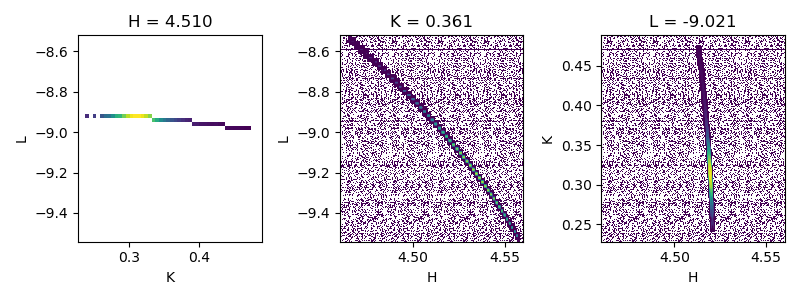

In [9]:
x,y,z,intensity = loadstack(1,1)
xlen, ylen, zlen = np.shape(intensity)
h_min,h_max = [np.min(x), np.max(x)]
k_min,k_max = [np.min(y), np.max(y)]
l_min,l_max = [np.min(z), np.max(z)]

fig = plt.figure(figsize=(8,3))

normalization = 'log'
x_slider = widgets.IntSlider(min=0, max=xlen-1, step=1, value=xlen//2, description='H Section:')
y_slider = widgets.IntSlider(min=0, max=ylen-1, step=1, value=ylen//2, description='K Section:')
z_slider = widgets.IntSlider(min=0, max=zlen-1, step=1, value=zlen//2, description='L Section:')

interact(plot_hyperspectral_data, x_section=x_slider, y_section=y_slider, z_section=z_slider)

plt.show()


/tmp/ipykernel_57140/307714564.py:3: RuntimeWarning: Mean of empty slice
  y_slice = np.nanmean(intensity, axis = 1)
/tmp/ipykernel_57140/307714564.py:11: RuntimeWarning: Mean of empty slice
  L_cut = np.nanmean(y_slice[:,len(y)//2-10:len(y)//2+10], axis = 1)# - np.nanmean(y_slice[:,len(y)//2+10:len(y)//2-10], axis = 1)


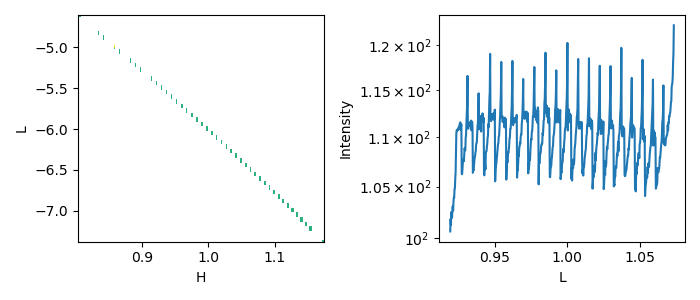

In [5]:
fig = plt.figure(figsize=(7,3))
intensity[intensity ==0.0] = np.nan
y_slice = np.nanmean(intensity, axis = 1)
ax2 = plt.subplot(121)#,aspect=1.0)
ax2.imshow(np.flipud(np.transpose(y_slice)), cmap='viridis', norm = normalization, aspect='auto', vmin = 2, vmax = 1e3,
           extent = (h_min,h_max, l_min*3,l_max*3))
ax2.set_xlabel('H')
ax2.set_ylabel('L')

plt.subplot(122)
L_cut = np.nanmean(y_slice[:,len(y)//2-10:len(y)//2+10], axis = 1)# - np.nanmean(y_slice[:,len(y)//2+10:len(y)//2-10], axis = 1)
plt.semilogy(x,L_cut)
plt.xlabel('L')
plt.ylabel('Intensity')
plt.tight_layout()
plt.show()

# z1, L_cut1 = z, L_cut


In [46]:
len(y)

50

scan number: 5, length: 201


/tmp/ipykernel_57140/2585754393.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  arr = np.fromstring(im.read(), dtype='int32')


interactive(children=(IntSlider(value=750, description='H Section:', max=1499), IntSlider(value=25, descriptio…

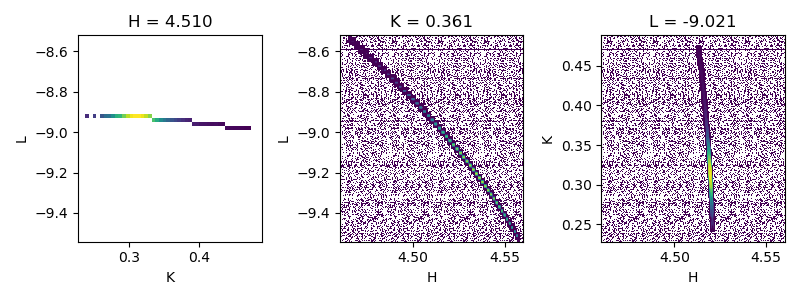

In [10]:
x,y,z,intensity = loadstack(23,23)
xlen, ylen, zlen = np.shape(intensity)

fig = plt.figure(figsize=(8,3))

normalization = 'log'
x_slider = widgets.IntSlider(min=0, max=xlen-1, step=1, value=xlen//2, description='H Section:')
y_slider = widgets.IntSlider(min=0, max=ylen-1, step=1, value=ylen//2, description='K Section:')
z_slider = widgets.IntSlider(min=0, max=zlen-1, step=1, value=zlen//2, description='L Section:')

interact(plot_hyperspectral_data, x_section=x_slider, y_section=y_slider, z_section=z_slider)

plt.show()


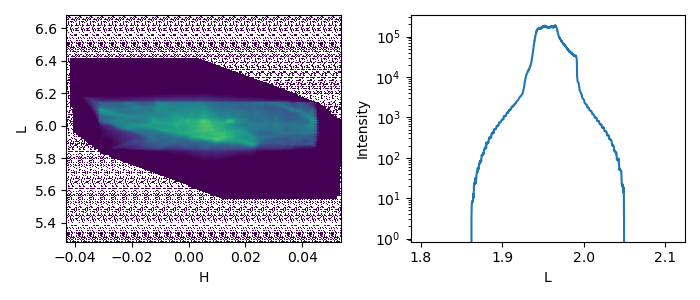

In [47]:
fig = plt.figure(figsize=(7,3))
intensity[intensity ==0.0] = np.nan
y_slice = np.nanmean(intensity, axis = 1)
ax2 = plt.subplot(121)#,aspect=1.0)
ax2.imshow(np.flipud(np.transpose(y_slice)), cmap='viridis', norm = normalization, aspect='auto', vmin = 100, vmax = 1e5,
           extent = (h_min,h_max, l_min*3,l_max*3))
ax2.set_xlabel('H')
ax2.set_ylabel('L')

plt.subplot(122)
L_cut = np.nanmean(y_slice[40:60], axis = 0)
plt.semilogy(z,L_cut)
plt.xlabel('L')
plt.ylabel('Intensity')
plt.tight_layout()
plt.show()

scan number: 35, length: 401


/tmp/ipykernel_576983/2585754393.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  arr = np.fromstring(im.read(), dtype='int32')


interactive(children=(IntSlider(value=50, description='H Section:', max=99), IntSlider(value=50, description='…

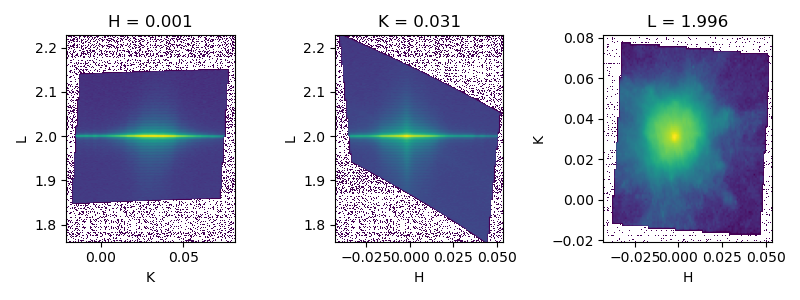

In [88]:
x,y,z,intensity = loadstack(35,35)
xlen, ylen, zlen = np.shape(intensity)

fig = plt.figure(figsize=(8,3))

normalization = 'log'
x_slider = widgets.IntSlider(min=0, max=xlen-1, step=1, value=xlen//2, description='H Section:')
y_slider = widgets.IntSlider(min=0, max=ylen-1, step=1, value=ylen//2, description='K Section:')
z_slider = widgets.IntSlider(min=0, max=zlen-1, step=1, value=zlen//2, description='L Section:')

interact(plot_hyperspectral_data, x_section=x_slider, y_section=y_slider, z_section=z_slider)

plt.show()


/tmp/ipykernel_576983/3942839631.py:3: RuntimeWarning: Mean of empty slice
  y_slice = np.nanmean(intensity, axis = 1)


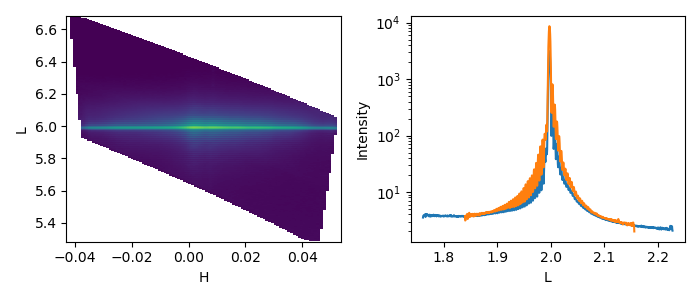

In [87]:
fig = plt.figure(figsize=(7,3))
intensity[intensity ==0.0] = np.nan
y_slice = np.nanmean(intensity, axis = 1)
ax2 = plt.subplot(121)#,aspect=1.0)
ax2.imshow(np.flipud(np.transpose(y_slice)), cmap='viridis', norm = normalization, aspect='auto', vmin = 3, vmax = 1e5,
           extent = (h_min,h_max, l_min*3,l_max*3))
ax2.set_xlabel('H')
ax2.set_ylabel('L')

plt.subplot(122)
L_cut = np.nanmean(y_slice, axis = 0)
plt.semilogy(z,L_cut)
plt.semilogy(z1,L_cut1)
plt.xlabel('L')
plt.ylabel('Intensity')
plt.tight_layout()
plt.show()



scan number: 38, length: 201


/tmp/ipykernel_576983/2585754393.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  arr = np.fromstring(im.read(), dtype='int32')


interactive(children=(IntSlider(value=50, description='H Section:', max=99), IntSlider(value=50, description='…

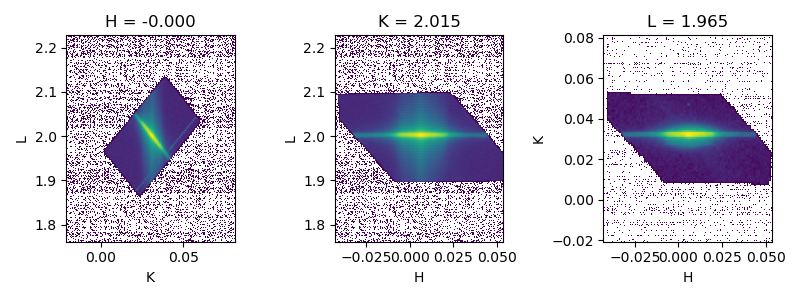

In [80]:
x,y,z,intensity = loadstack(38,38)
xlen, ylen, zlen = np.shape(intensity)

fig = plt.figure(figsize=(8,3))

normalization = 'log'
x_slider = widgets.IntSlider(min=0, max=xlen-1, step=1, value=xlen//2, description='H Section:')
y_slider = widgets.IntSlider(min=0, max=ylen-1, step=1, value=ylen//2, description='K Section:')
z_slider = widgets.IntSlider(min=0, max=zlen-1, step=1, value=zlen//2, description='L Section:')

interact(plot_hyperspectral_data, x_section=x_slider, y_section=y_slider, z_section=z_slider)

plt.show()


/tmp/ipykernel_576983/1338578731.py:3: RuntimeWarning: Mean of empty slice
  y_slice = np.nanmean(intensity, axis = 1)


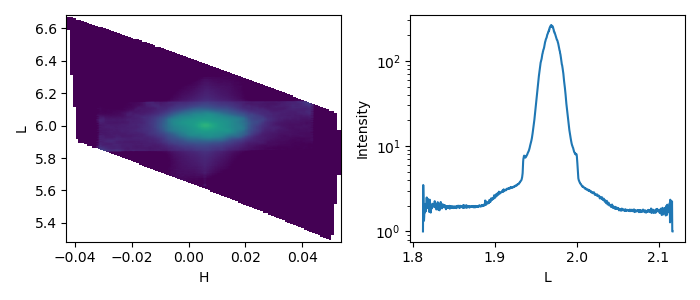

In [81]:
fig = plt.figure(figsize=(7,3))
intensity[intensity ==0.0] = np.nan
y_slice = np.nanmean(intensity, axis = 1)
ax2 = plt.subplot(121)#,aspect=1.0)
ax2.imshow(np.flipud(np.transpose(y_slice)), cmap='viridis', norm = normalization, aspect='auto', vmin = 3, vmax = 1e5,
           extent = (h_min,h_max, l_min*3,l_max*3))
ax2.set_xlabel('H')
ax2.set_ylabel('L')

plt.subplot(122)
L_cut = np.nanmean(y_slice, axis = 0)
plt.semilogy(z,L_cut)
plt.xlabel('L')
plt.ylabel('Intensity')
plt.tight_layout()
plt.show()



In [1]:
%matplotlib ipympl

import numpy as np
import xrayutilities as xu
import matplotlib.pyplot as plt
from silx.io.specfile import SpecFile,Scan
from matplotlib import gridspec
import os
import fabio
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact

def read_TIFF(file):
    print("Reading TIFF file here...")
    try:
        im = open(file, 'rb')
        im.seek(4096)	# skip the first 4096 bytes of header info for TIFF images
        arr = np.fromstring(im.read(), dtype='int32')
        im.close()
        arr.shape = (195, 487)
        #arr = np.fliplr(arr)  #for the way mounted at BL2-1
        print(np.shape(arr))
        print(len(arr))
        return arr
    except:
        print("Error reading file: %s" % file)
        return None

def read_RAW(file):
    #print(f"Reading {os.path.basename(file)}...")
    try:
        im = open(file, 'rb')
        arr = np.fromstring(im.read(), dtype='int32')
        im.close()
        arr.shape = (195, 487)
        #arr = np.fliplr(arr)  #for the way mounted at BL2-1
        return arr
    except:
        print("Error reading file: %s" % file)
        return None


def loadstack(scan_num1, scan_num2):
    # Useful information for calibration goes here
    scan_num = 5

    db_pixel = [238, 98]  # direct beam pixel
    pix_size = 172.0  # pixel size in microns

    data_path = "/msd_data/checkout/bl17-2/user_data/2023_12_Yayoi/images/"
    data_name = "checkout_RSM_IN043_scan"+str(scan_num)+"_"

    csv_path = "/msd_data/checkout/bl17-2/user_data/2023_12_Yayoi/RSM/"
    csv_name = "RSM_IN043_scan1"+str(scan_num)+".csv"
    csv_file = os.path.join(csv_path, csv_name)

    spec_path = csv_path
    spec_name = 'RSM_IN043'
    spec_file = os.path.join(spec_path, spec_name)

    motor_name = "RSM_IN043_scan"+str(scan_num).zfill(3)+"_hklscan_motors.txt"
    motor_file = os.path.join(spec_path, motor_name)

    # Read SPEC file, get headers
    sf = SpecFile(spec_file)
    scan = sf[scan_num-1]
    num_points = np.shape(scan.data)[1]
    print('scan number: ' + str(scan.number) + ', length: ' + str(np.shape(scan.data)[1]))

    for line in scan.header:
        if line[:3] == '#G3':
            UB = np.array(line.split(' ')[-9:]).astype(float).reshape([3,3])
        if line[:3] == '#P0':
            angles = np.array(line.split(' ')[1:-2]).astype(float)
        if line[:4] == '#P15':
            energy = np.array(line.split(' ')[4]).astype(float)

    try:
        tt = scan.data_column_by_name('del')
    except:
        tt = angles[0] * np.ones(np.shape(scan.data)[1])

    try:
        eta = scan.data_column_by_name('eta')
    except:
        eta = angles[1] * np.ones(np.shape(scan.data)[1])

    try:
        chi = scan.data_column_by_name('chi')
    except:
        chi = angles[2] * np.ones(np.shape(scan.data)[1])

    try:
        phi = scan.data_column_by_name('phi')
    except:
        phi = angles[3] * np.ones(np.shape(scan.data)[1])

    # read images
    for i in np.arange(0, num_points):
        filename = data_path + data_name + str(i).zfill(4) + ".raw"
        data = np.swapaxes(read_RAW(filename),0,1)
        if i==0:
            img = [data]
        else:
            img += [data]

    qconversion = xu.QConversion(sampleAxis = ['z-','y+','z-'], detectorAxis = ['z-'], r_i = [0,1,0])

    hxrd = xu.HXRD( [0,1,0], [0,0,1], en = energy, qconv =  qconversion)

    hxrd.Ang2Q.init_area(
            'x-', 'z-',
            cch1=238, cch2=98,
            Nch1=487, Nch2=195,
            pwidth1=0.172, pwidth2=0.172,
            distance=963.885
        )

    angle_values =   [eta, chi, phi, tt]   #[[26.056],  [13.028]]
    qx, qy, qz = hxrd.Ang2Q.area(*angle_values, UB=UB)

    q1 = qx + qy + qz
    q2 = qx - qy
    q3 = qx +qy - 2*qz
    img = np.array(img)

    # Define the hkl grids to bin the diffraction data
    h_min,h_max = [np.min(q1), np.max(q1)]
    k_min,k_max = [np.min(q2), np.max(q2)]
    l_min,l_max = [np.min(q3), np.max(q3)]
    h_n, k_n, l_n = [1500, 50, 50]
    
    gridder = xu.Gridder3D(nx=h_n, ny=k_n, nz=l_n)
    gridder.KeepData(True)
    gridder.dataRange(
        xmin=h_min, xmax=h_max,
        # xmin=2.5, xmax=3.5,
        ymin=k_min, ymax=k_max,
        zmin=l_min, zmax=l_max,
        fixed=True
    )
    gridder(q1, q2, q3, img)


    # The output, the intensity and corresponding h,k,l 
    intensity = gridder.data.astype(float)
    x,y,z = gridder.xaxis, gridder.yaxis, gridder.zaxis
    return x,y,z,intensity

def plot_hyperspectral_data(x_section,y_section,z_section):
    x_slice = intensity[x_section, :, :]
    y_slice = intensity[:, y_section, :]
    z_slice = intensity[:, :, z_section]
    
    ax1 = plt.subplot(131)#,aspect=1.0)
    ax1.imshow(np.flipud(np.transpose(x_slice)), cmap='viridis', norm = normalization, aspect='auto', 
               extent = (k_min,k_max, l_min,l_max))
    ax1.set_xlabel('K')
    ax1.set_ylabel('L')
    ax1.set_title(f'H = {x[x_section]:.3f}')
    # ax1.set_aspect('equal')
    
    ax2 = plt.subplot(132)#,aspect=1.0)
    ax2.imshow(np.flipud(np.transpose(y_slice)), cmap='viridis', norm = normalization, aspect='auto', 
               extent = (h_min,h_max, l_min,l_max))
    ax2.set_xlabel('H')
    ax2.set_ylabel('L')
    ax2.set_title(f'K = {y[y_section]:.3f}')
    # ax2.set_aspect('equal')    
    
    ax3 = plt.subplot(133)#,aspect=1.0)
    ax3.imshow(np.flipud(np.transpose(z_slice)), cmap='viridis', norm = normalization, aspect='auto', 
               extent = (h_min,h_max, k_min,k_max))
    ax3.set_xlabel('H')
    ax3.set_ylabel('K')
    ax3.set_title(f'L = {z[z_section]:.3f}')
    # ax3.set_aspect('equal')
    plt.tight_layout()



x,y,z,intensity = loadstack(1,1)
xlen, ylen, zlen = np.shape(intensity)
h_min,h_max = [np.min(x), np.max(x)]
k_min,k_max = [np.min(y), np.max(y)]
l_min,l_max = [np.min(z), np.max(z)]

fig = plt.figure(figsize=(8,3))

normalization = 'log'
x_slider = widgets.IntSlider(min=0, max=xlen-1, step=1, value=xlen//2, description='H Section:')
y_slider = widgets.IntSlider(min=0, max=ylen-1, step=1, value=ylen//2, description='K Section:')
z_slider = widgets.IntSlider(min=0, max=zlen-1, step=1, value=zlen//2, description='L Section:')

interact(plot_hyperspectral_data, x_section=x_slider, y_section=y_slider, z_section=z_slider)

plt.show()


fig = plt.figure(figsize=(7,3))
intensity[intensity ==0.0] = np.nan
y_slice = np.nanmean(intensity, axis = 1)
ax2 = plt.subplot(121)#,aspect=1.0)
ax2.imshow(np.flipud(np.transpose(y_slice)), cmap='viridis', norm = normalization, aspect='auto', vmin = 3, vmax = 1e5,
           extent = (h_min,h_max, l_min*3,l_max*3))
ax2.set_xlabel('H')
ax2.set_ylabel('L')

plt.subplot(122)
L_cut = np.nanmean(y_slice, axis = 0)
plt.semilogy(z,L_cut)
plt.semilogy(z1,L_cut1)
plt.xlabel('L')
plt.ylabel('Intensity')
plt.tight_layout()
plt.show()